In [47]:
NAME = "Piotr Szuba"

In [48]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
warnings.filterwarnings("ignore", category=FutureWarning, module="scipy")

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
from typing import List, Tuple, Dict, Literal, Union
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import (
    davies_bouldin_score,
    adjusted_rand_score,
    completeness_score,
    silhouette_score,
    confusion_matrix,
    precision_score,
    accuracy_score,
    recall_score,
    f1_score,
)

random_state = 1

In [50]:
def convert_cell(series: pd.Series):
    converted = pd.to_numeric(series, errors="coerce", downcast="float")
    converted = converted.replace([np.inf, -np.inf], np.nan)
    converted = converted.fillna(np.nan)
    return converted


def clear_data(data: pd.DataFrame):
    columns = data.columns
    df = data[columns].apply(lambda x: convert_cell(x))

    imputer = SimpleImputer(missing_values=np.nan, strategy="median")
    imputed_df = pd.DataFrame(imputer.fit_transform(df), columns=columns)

    return imputed_df


def drop_target_feature(X: pd.DataFrame, target_feature: str):
    X = X.drop(target_feature, axis=1)
    return X


def scale_numeric_features(X: np.ndarray) -> np.ndarray:
    scaler = StandardScaler()

    X_scaled = scaler.fit_transform(X)

    return X_scaled


def apply_pca(X: np.ndarray, components: int = 2) -> np.ndarray:
    n_features = X.shape[1]
    n_components = min(components, n_features)
    pca = PCA(n_components=n_components)

    X_pca = pca.fit_transform(X)

    return X_pca


def predict(clf: Union[DBSCAN, KMeans], X: np.ndarray) -> np.ndarray:
    if isinstance(clf, DBSCAN):
        clf.fit(X)
        labels = clf.labels_
    elif isinstance(clf, KMeans):
        clf.fit(X)
        labels = clf.predict(X)

    return labels


def Compute_scores(
    data: pd.DataFrame,
    target_feature: str,
    clf: Union[DBSCAN, KMeans],
    pca_comps: Union[int, None] = None,
):
    X = drop_target_feature(data, target_feature)
    X = clear_data(X)

    X = scale_numeric_features(X)
    if pca_comps is not None:
        X = apply_pca(X, pca_comps)

    labels = predict(clf, X)

    return clf, X, labels

In [51]:
def interpret_silhouette_score(score):
    if score < 0.2:
        return "Very Bad"
    elif score < 0.4:
        return "Bad"
    elif score < 0.6:
        return "Fair"
    elif score < 0.8:
        return "Good"
    else:
        return "Very Good"


def interpret_davies_bouldin_index(index):
    if index < 0.2:
        return "Very Good"
    elif index < 0.4:
        return "Good"
    elif index < 0.6:
        return "Fair"
    elif index < 0.8:
        return "Bad"
    else:
        return "Very Bad"


def interpret_rand_index(index):
    if index < 0.2:
        return "Very Bad"
    elif index < 0.4:
        return "Bad"
    elif index < 0.6:
        return "Fair"
    elif index < 0.8:
        return "Good"
    else:
        return "Very Good"


def interpret_purity(purity):
    if purity < 0.3:
        return "Very Low"
    elif purity < 0.5:
        return "Low"
    elif purity < 0.7:
        return "Moderate"
    elif purity < 0.9:
        return "High"
    else:
        return "Very High"


def purity_score(y_true, labels):
    unique_labels = np.unique(labels)
    total_purity = 0.0
    label_encoder = LabelEncoder()
    y_true_encoded = label_encoder.fit_transform(y_true)

    for cluster_label in unique_labels:
        cluster_indices = np.where(labels == cluster_label)[0]
        true_labels_in_cluster = y_true_encoded[cluster_indices]
        label_counts = np.bincount(true_labels_in_cluster)
        max_count = np.max(label_counts)
        cluster_purity = max_count / len(cluster_indices)
        total_purity += cluster_purity

    average_purity = total_purity / len(unique_labels)

    return average_purity


def get_scores(orginal_data: pd.DataFrame, target: str, X, labels, print_results=True):
    y_true = orginal_data[target]
    if len(np.unique(labels)) < 2:
        silhouette = -1
        davies_bouldin = 1
        rand_index = -1
        purity = 0
    else:
        silhouette = silhouette_score(X, labels)
        davies_bouldin = davies_bouldin_score(X, labels)
        rand_index = adjusted_rand_score(y_true, labels)
        purity = purity_score(y_true, labels)
    silhouette_label = interpret_silhouette_score(silhouette)
    davies_bouldin_label = interpret_davies_bouldin_index(davies_bouldin)
    rand_index_label = interpret_rand_index(rand_index)
    purity_label = interpret_purity(purity)

    if print_results:
        print("Silhouette Score: {:.4f} => {}".format(silhouette, silhouette_label))
        print(
            "Davies-Bouldin Index: {:.4f} => {}".format(
                davies_bouldin, davies_bouldin_label
            )
        )
        print("Rand Index: {:.4f} => {}".format(rand_index, rand_index_label))
        print("Purity: {:.4f} => {}".format(purity, purity_label))

    return silhouette, davies_bouldin, rand_index, purity

<h1>Visual utilis<h1>

In [52]:
class Line:
    def __init__(self, name: str, data: List[tuple[float, str]]) -> None:
        self.name = name
        self.data = data

    def get_values(self):
        return [x[0] for x in self.data]

    def get_labels(self):
        return [x[1] for x in self.data]


class Plotter:
    def __init__(self, data: List[Line] = []) -> None:
        self.data = data

    def add_line(self, name: str, values: List[tuple[float, str]]) -> None:
        line_index = self._find_line_idx(name)

        if line_index == -1:
            line = Line(name, values)
            self.data.append(line)
            return

        self.data[line_index].data.extend(values)

    def remove_line(self, name: str) -> None:
        line_index = self._find_line_idx(name)

        if line_index != -1:
            del self.data[line_index]

    def get_line(self, name: str) -> Dict[str, List]:
        line_index = self._find_line_idx(name)
        if line_index == -1:
            return None
        return self.data[line_index]

    def get_all_lines(self) -> List[Line]:
        return self.data

    def plot(self) -> None:
        for line in self.data:
            plt.plot(line.get_labels(), line.get_values(), label=line.name)
        plt.xlabel("Labels")
        plt.ylabel("Values")
        plt.legend()
        plt.show()

    def clear(self):
        self.data = []

    def _find_line_idx(self, name: str):
        line_index = -1
        for i, line in enumerate(self.data):
            if line.name != name:
                continue
            line_index = i
            break
        return line_index


def plot_clusters(orginal_df: pd.DataFrame, labels):
    df = orginal_df.copy()
    df["cluster"] = labels
    grid = sns.pairplot(df, hue="cluster")
    grid.map_diag(sns.histplot)
    grid.map_offdiag(sns.scatterplot)
    grid.add_legend()


def bar_plot(values, labels):
    num_values = len(values)
    positions = range(num_values)

    plt.bar(positions, values, align="center")
    plt.xticks(positions, labels)
    plt.xlabel("Labels")
    plt.ylabel("Values")
    plt.title("Bar Plot")

    plt.show()

In [53]:
class DataClass:
    target_feature: str = ""

    def get_dataFrame() -> pd.DataFrame:
        raise NotImplementedError()

In [54]:
class Iris(DataClass):
    sepal_length = "sepal-length"
    sepal_width = "sepal-width"
    petal_length = "petal-length"
    petal_width = "petal-width"
    target_feature = "class"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "iris.data",
            names=[
                Iris.sepal_length,
                Iris.sepal_width,
                Iris.petal_length,
                Iris.petal_width,
                Iris.target_feature,
            ],
        )

        return data

In [55]:
class Seeds(DataClass):
    target_feature = "class"

    def format_file():
        input_file = "seeds_dataset.txt"
        output_file = "seeds_dataset_reformatted.txt"

        with open(input_file, "r") as f_in, open(output_file, "w") as f_out:
            for line in f_in:
                line = line.replace("\t\t\t", "\t")
                line = line.replace("\t\t", "\t")
                line = line.replace("\t", ",")
                line = line.replace(" ", "")
                f_out.write(line)

    def get_dataFrame() -> pd.DataFrame:
        Seeds.format_file()
        data = pd.read_csv(
            "seeds_dataset_reformatted.txt",
            names=[
                "area A",
                "perimeter P",
                "compactness C = 4*pi*A/P^2",
                "length of kernel",
                "width of kernel",
                "asymmetry coefficient",
                "length of kernel groove",
                Seeds.target_feature,
            ],
        )

        return data

In [56]:
class Glass(DataClass):
    target_feature = "Type of glass"

    def get_dataFrame() -> pd.DataFrame:
        data = pd.read_csv(
            "glass.data",
            names=[
                "Id number: 1 to 214",
                "RI: refractive index",
                "Na: Sodium",
                "Mg: Magnesium",
                "Al: Aluminum",
                "Si: Silicon",
                "K: Potassium",
                "Ca: Calcium",
                "Ba: Barium",
                "Fe: Iron",
                Glass.target_feature,
            ],
        )

        return data

In [57]:
class Pcb(DataClass):
    target_feature = "class (0,1)"

    def get_dataFrame(year: int = 1) -> pd.DataFrame:
        data = pd.read_csv(
            f"{year}year.csv",
            names=[
                "net profit / total assets",
                "total liabilities / total assets",
                "working capital / total assets",
                "current assets / short-term liabilitiesl",
                "[(cash + short-term securities + receivables - short-term liabilities) / (operating expenses - depreciation)] * 365",
                "retained earnings / total assets",
                "EBIT / total assets",
                "book value of equity / total liabilities",
                "sales / total assets",
                "equity / total assets",
                "(gross profit + extraordinary items + financial expenses) / total assets",
                "gross profit / short-term liabilities",
                "(gross profit + depreciation) / sales",
                "(gross profit + interest) / total assets",
                "(total liabilities * 365) / (gross profit + depreciation)",
                "(gross profit + depreciation) / total liabilities",
                "total assets / total liabilities",
                "gross profit / total assets",
                "gross profit / sales",
                "(inventory * 365) / sales",
                "sales (n) / sales (n-1)",
                "profit on operating activities / total assets",
                "net profit / sales",
                "gross profit (in 3 years) / total assets",
                "(equity - share capital) / total assets",
                "(net profit + depreciation) / total liabilities",
                "profit on operating activities / financial expenses",
                "working capital / fixed assets",
                "logarithm of total assets",
                "(total liabilities - cash) / sales",
                "(gross profit + interest) / sales",
                "(current liabilities * 365) / cost of products sold",
                "operating expenses / short-term liabilities",
                "operating expenses / total liabilities",
                "profit on sales / total assets",
                "total sales / total assets",
                "(current assets - inventories) / long-term liabilities",
                "constant capital / total assets",
                "profit on sales / sales",
                "(current assets - inventory - receivables) / short-term liabilities",
                "total liabilities / ((profit on operating activities + depreciation) * (12/365))",
                "profit on operating activities / sales",
                "rotation receivables + inventory turnover in days",
                "(receivables * 365) / sales",
                "net profit / inventory",
                "(current assets - inventory) / short-term liabilities",
                "(inventory * 365) / cost of products sold",
                "EBITDA (profit on operating activities - depreciation) / total assets",
                "EBITDA (profit on operating activities - depreciation) / sales",
                "current assets / total liabilities",
                "short-term liabilities / total assets",
                "(short-term liabilities * 365) / cost of products sold)",
                "equity / fixed assets",
                "constant capital / fixed assets",
                "working capita",
                "(sales - cost of products sold) / sales",
                "(current assets - inventory - short-term liabilities) / (sales - gross profit - depreciation)",
                "total costs /total sales",
                "long-term liabilities / equity",
                "sales / inventory",
                "sales / receivables",
                "(short-term liabilities *365) / sales",
                "sales / short-term liabilities",
                "sales / fixed assets",
                Pcb.target_feature,
            ],
        )

        return data

<h1>Sanity check IRIS<h1>

In [58]:
iris_plotter = Plotter()
iris_plotter.clear()
iris_df = Iris.get_dataFrame()
kmeans = KMeans(n_clusters=3, max_iter=300, random_state=random_state)
clf, X, labels = Compute_scores(iris_df, Iris.target_feature, kmeans)

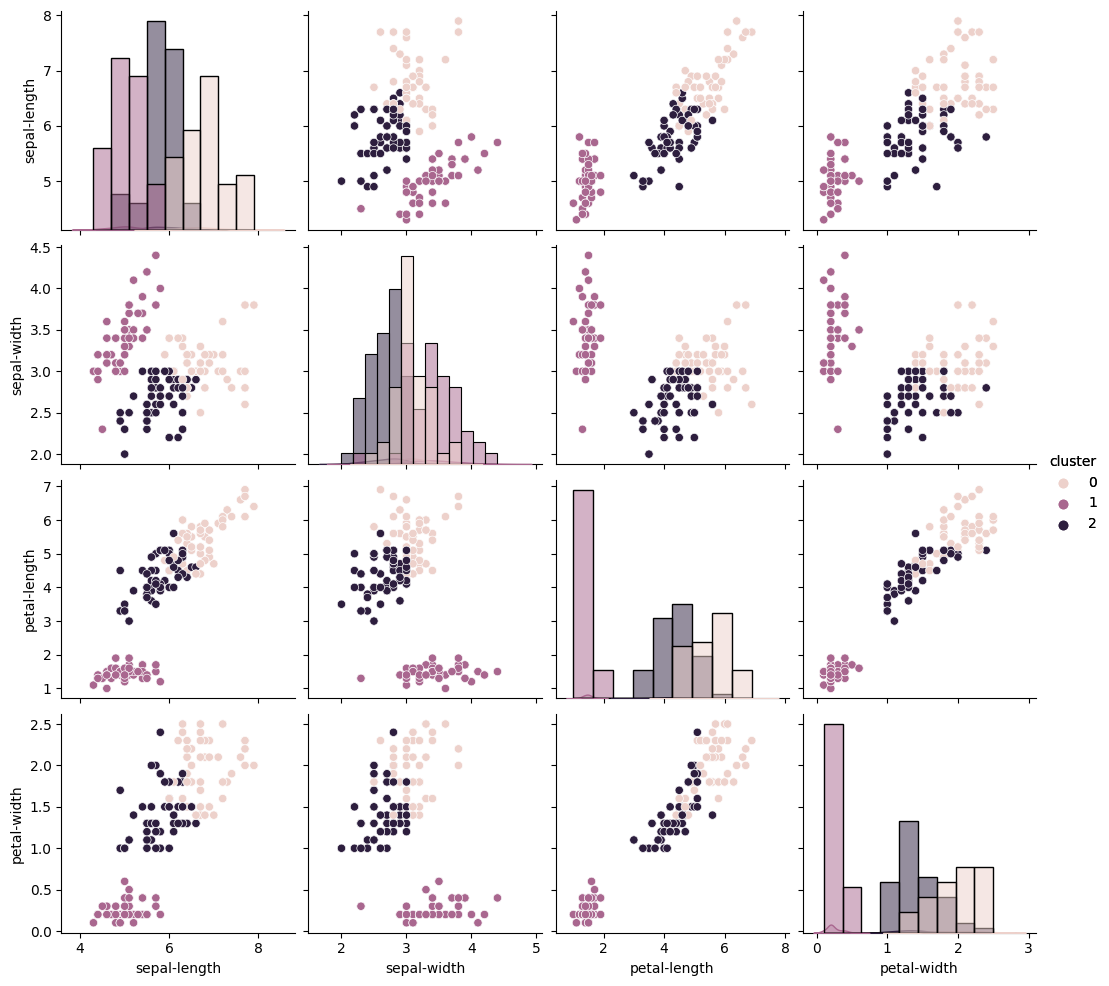

In [59]:
plot_clusters(iris_df, labels)

In [60]:
silhouette, davies_bouldin, rand_index, purity = get_scores(
    iris_df, Iris.target_feature, X, labels
)
iris_plotter.add_line("silhouette", [[silhouette, "3 clusters"]])
iris_plotter.add_line("davies_bouldin", [[davies_bouldin, "3 clusters"]])
iris_plotter.add_line("rand_index", [[rand_index, "3 clusters"]])
iris_plotter.add_line("purity", [[purity, "3 clusters"]])

Silhouette Score: 0.4590 => Fair
Davies-Bouldin Index: 0.8354 => Very Bad
Rand Index: 0.6201 => Good
Purity: 0.8339 => High


Silhouette Score: 0.5802 => Fair
Davies-Bouldin Index: 0.5976 => Fair
Rand Index: 0.5681 => Fair
Purity: 0.7500 => High


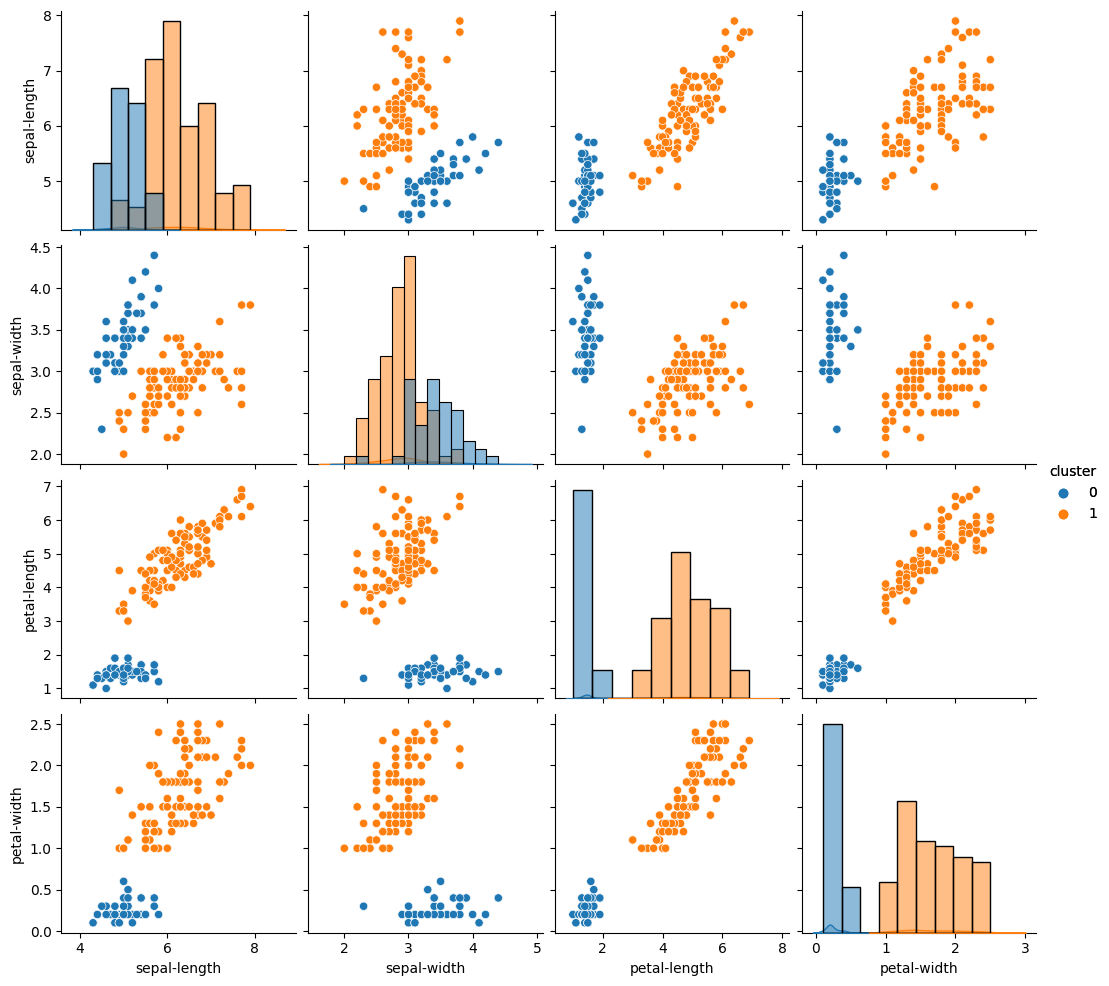

In [61]:
iris_df = Iris.get_dataFrame()
kmeans_2 = KMeans(n_clusters=2, max_iter=300, random_state=random_state)
_, X_2, labels_2 = Compute_scores(iris_df, Iris.target_feature, kmeans_2)
plot_clusters(iris_df, labels_2)
silhouette, davies_bouldin, rand_index, purity = get_scores(
    iris_df, Iris.target_feature, X_2, labels_2
)
iris_plotter.add_line("silhouette", [[silhouette, "2 clusters"]])
iris_plotter.add_line("davies_bouldin", [[davies_bouldin, "2 clusters"]])
iris_plotter.add_line("rand_index", [[rand_index, "2 clusters"]])
iris_plotter.add_line("purity", [[purity, "2 clusters"]])

Silhouette Score: 0.3872 => Bad
Davies-Bouldin Index: 0.8656 => Very Bad
Rand Index: 0.4933 => Fair
Purity: 0.8851 => High


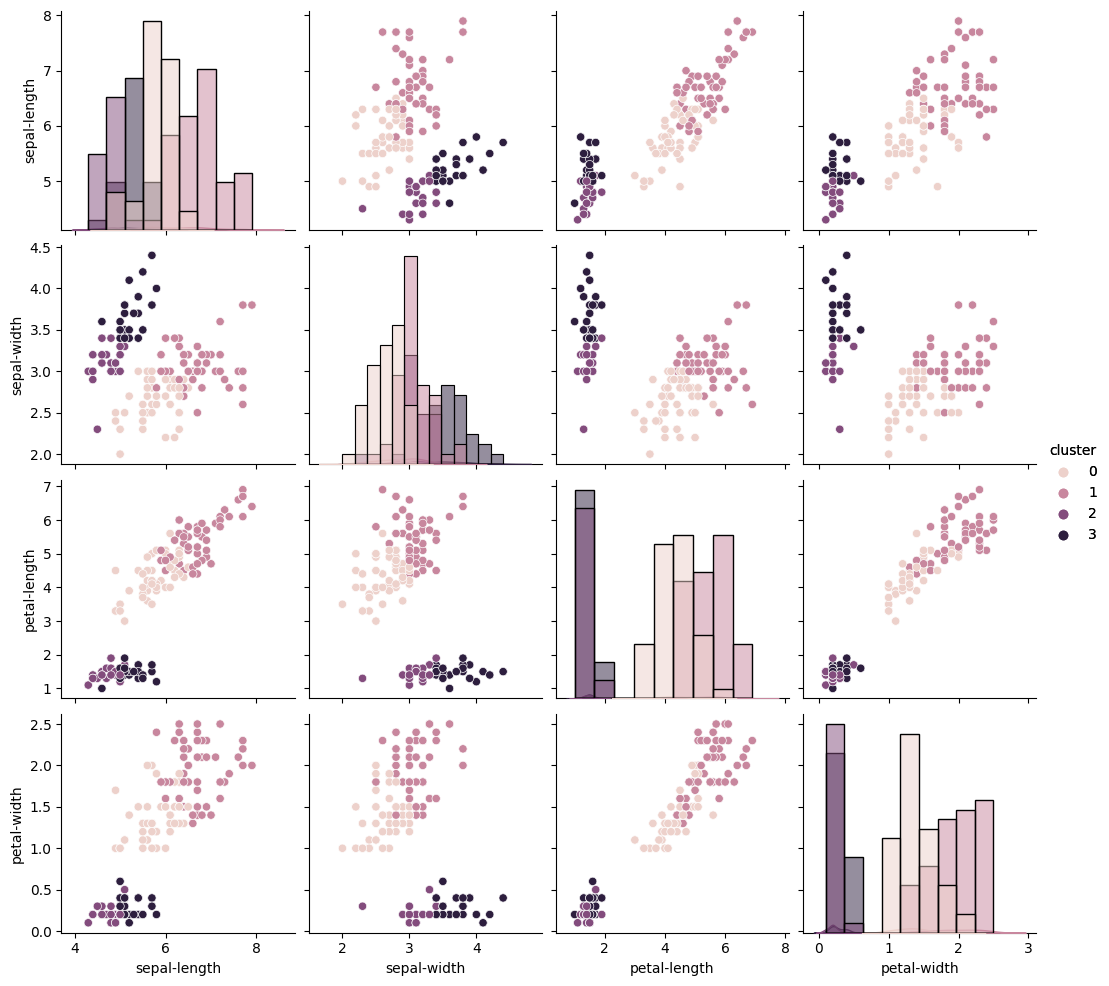

In [62]:
iris_df = Iris.get_dataFrame()
kmeans_4 = KMeans(n_clusters=4, max_iter=300, random_state=random_state)
_, X_4, labels_4 = Compute_scores(iris_df, Iris.target_feature, kmeans_4)
plot_clusters(iris_df, labels_4)
silhouette, davies_bouldin, rand_index, purity = get_scores(
    iris_df, Iris.target_feature, X_4, labels_4
)
iris_plotter.add_line("silhouette", [[silhouette, "4 clusters"]])
iris_plotter.add_line("davies_bouldin", [[davies_bouldin, "4 clusters"]])
iris_plotter.add_line("rand_index", [[rand_index, "4 clusters"]])
iris_plotter.add_line("purity", [[purity, "4 clusters"]])

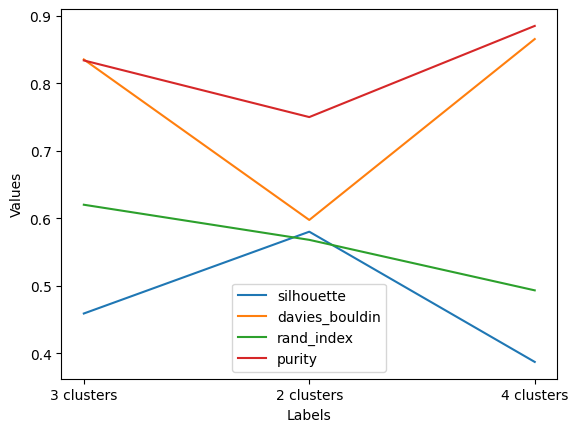

In [63]:
iris_plotter.plot()

In [84]:
def kmeans_full_test(data_class: DataClass) -> pd.DataFrame:
    df = data_class.get_dataFrame()
    n_clusters = [2, 3, 4, 5, 7, 10]
    n_inits = [1, 3, 5, 10]
    max_iters = [100, 200, 300, 500]

    results = []
    for n_cluster in n_clusters:
        for n_init in n_inits:
            for max_iter in max_iters:
                kmeans = KMeans(
                    n_clusters=n_cluster,
                    n_init=n_init,
                    max_iter=max_iter,
                    random_state=random_state,
                )
                _, X, labels = Compute_scores(df, data_class.target_feature, kmeans)
                silhouette, davies_bouldin, rand_index, purity = get_scores(
                    df, data_class.target_feature, X, labels, print_results=False
                )
                result = {
                    "n_cluster": n_cluster,
                    "n_init": n_init,
                    "max_iter": max_iter,
                    "silhouette": silhouette,
                    "davies_bouldin": davies_bouldin,
                    "rand_index": rand_index,
                    "purity": purity,
                }
                results.append(result)
    results_df = pd.DataFrame(results)

    return results_df


def dbscab_full_test(data_class: DataClass) -> pd.DataFrame:
    df = data_class.get_dataFrame()
    eps = [0.1, 0.3, 0.5, 0.7, 0.9]
    min_samples = [3, 5, 7]
    metrics = ["euclidean", "manhattan", "cosine"]

    results = []
    for ep in eps:
        for min_sample in min_samples:
            for metric in metrics:
                dbscab = DBSCAN(eps=ep, min_samples=min_sample, metric=metric)
                _, X, labels = Compute_scores(df, data_class.target_feature, dbscab)
                silhouette, davies_bouldin, rand_index, purity = get_scores(
                    df, data_class.target_feature, X, labels, print_results=False
                )
                result = {
                    "eps": ep,
                    "min_samples": min_sample,
                    "metric": metric,
                    "silhouette": silhouette,
                    "davies_bouldin": davies_bouldin,
                    "rand_index": rand_index,
                    "purity": purity,
                }
                results.append(result)
    results_df = pd.DataFrame(results)

    return results_df


def get_average_for(result: pd.DataFrame, param: str, metric: str):
    avg_scores = result.groupby(param)[metric].mean()
    avg_scores_df = avg_scores.reset_index()
    avg_scores_df.columns = [param, metric]
    return avg_scores_df


def plot_avg_scores(
    result: pd.DataFrame,
    param: Literal["n_cluster", "n_init", "max_iter"],
    metrics: List[Literal["silhouette", "davies_bouldin", "rand_index", "purity"]],
):
    plt.figure(figsize=(10, 6))

    for metric in metrics:
        avg_scores = get_average_for(result, param, metric)
        plt.plot(
            avg_scores[param],
            avg_scores[metric],
            marker="o",
            linestyle="-",
            label=metric.capitalize(),
        )

    plt.xlabel(f"{param} value")
    plt.ylabel(f"Average metric")
    plt.title(f"Average metric for Different parameter values")
    plt.legend()
    plt.show()


def plot_all_avg_scores_kmeans(result: pd.DataFrame):
    metrics = ["silhouette", "davies_bouldin", "rand_index", "purity"]
    plot_avg_scores(result, "n_cluster", metrics)
    plot_avg_scores(result, "n_init", metrics)
    plot_avg_scores(result, "max_iter", metrics)


def plot_all_avg_scores_dbscan(result: pd.DataFrame):
    metrics = ["silhouette", "davies_bouldin", "rand_index", "purity"]
    plot_avg_scores(result, "eps", metrics)
    plot_avg_scores(result, "min_samples", metrics)
    plot_avg_scores(result, "metric", metrics)


def extract_hyperparams_kmeans(result: pd.Series):
    n_cluster = result["n_cluster"]
    n_init = result["n_init"]
    max_iter = result["max_iter"]
    return n_cluster, n_init, max_iter


def extract_hyperparams_dbscan(result: pd.Series):
    eps = result["eps"]
    min_samples = result["min_samples"]
    metric = result["metric"]
    return eps, min_samples, metric


def extract_best_result(df: pd.DataFrame) -> pd.Series:
    scores = df[["silhouette", "rand_index", "purity"]]
    scores = scores.assign(mean_score=scores.mean(axis=1))
    scores = scores.assign(davies_bouldin=df["davies_bouldin"])
    scores = scores.assign(
        weighted_score=0.75 * scores["mean_score"] - 0.25 * scores["davies_bouldin"]
    )
    best_idx = scores["weighted_score"].idxmax()
    best_result = df.loc[best_idx]
    return best_result


def plot_best_kmeans(result: pd.DataFrame, dataclass: DataClass):
    best = extract_best_result(result)
    n_cluster, n_init, max_iter = extract_hyperparams_kmeans(best)

    df = dataclass.get_dataFrame()
    kmeans = KMeans(
        n_clusters=int(n_cluster),
        max_iter=int(max_iter),
        n_init=int(n_init),
        random_state=random_state,
    )
    _, X, labels = Compute_scores(df, dataclass.target_feature, kmeans)

    get_scores(df, dataclass.target_feature, X, labels, print_results=True)
    df = drop_target_feature(df, dataclass.target_feature)
    plot_clusters(df, labels)


def plot_best_dbscan(
    result: pd.DataFrame, dataclass: DataClass, pca_comps: Union[int, None] = None
):
    best = extract_best_result(result)
    eps, min_samples, metric = extract_hyperparams_dbscan(best)

    df = dataclass.get_dataFrame()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    _, X, labels = Compute_scores(df, dataclass.target_feature, dbscan, pca_comps)

    get_scores(df, dataclass.target_feature, X, labels, print_results=True)
    df = drop_target_feature(df, dataclass.target_feature)
    columns = [f"pca-{i+1}" for i in range(pca_comps)] if pca_comps else df.columns
    plot_clusters(pd.DataFrame(X, columns=columns), labels)


def get_scores_for_best_kmeans(result: pd.DataFrame, dataclass: DataClass):
    best = extract_best_result(result)
    n_cluster, n_init, max_iter = extract_hyperparams_kmeans(best)

    df = dataclass.get_dataFrame()
    kmeans = KMeans(
        n_clusters=int(n_cluster),
        max_iter=int(max_iter),
        n_init=int(n_init),
        random_state=random_state,
    )
    _, X, labels = Compute_scores(df, dataclass.target_feature, kmeans)

    get_scores(df, dataclass.target_feature, X, labels, print_results=True)

    return df, labels


def get_scores_for_best_dbscan(result: pd.DataFrame, dataclass: DataClass):
    best = extract_best_result(result)
    eps, min_samples, metric = extract_hyperparams_dbscan(best)

    df = dataclass.get_dataFrame()
    dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
    _, X, labels = Compute_scores(df, dataclass.target_feature, dbscan)

    get_scores(df, dataclass.target_feature, X, labels, print_results=True)

    return df, labels


def plot_scatter(orginal_df: pd.DataFrame, labels, feature1: str, feature2: str):
    df = orginal_df.copy()
    df["cluster"] = labels
    plt.scatter(df[feature1], df[feature2], c=df["cluster"])
    plt.xlabel(feature1)
    plt.ylabel(feature2)
    plt.title("Cluster Plot")
    plt.colorbar(label="Cluster")
    plt.show()


def get_scores_for_best_kmeans_with_plot(
    result: pd.DataFrame, dataclass: DataClass, feature1: str, feature2: str
):
    df, labels = get_scores_for_best_kmeans(result, dataclass)
    plot_scatter(df, labels, feature1, feature2)


def get_scores_for_best_dbscan_with_plot(
    result: pd.DataFrame, dataclass: DataClass, feature1: str, feature2: str
):
    df, labels = get_scores_for_best_dbscan(result, dataclass)
    plot_scatter(df, labels, feature1, feature2)

<h1>SEEDS KMEANS<h1>

In [65]:
seeds_result = kmeans_full_test(Seeds)

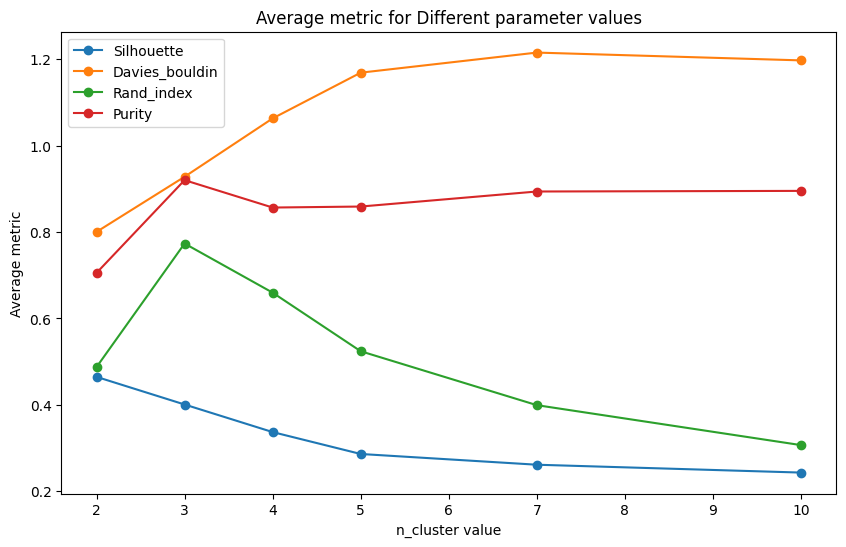

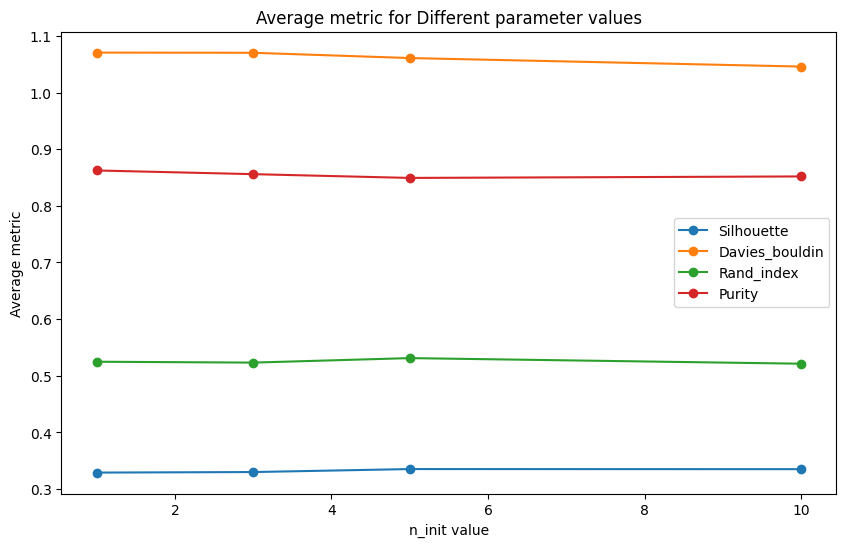

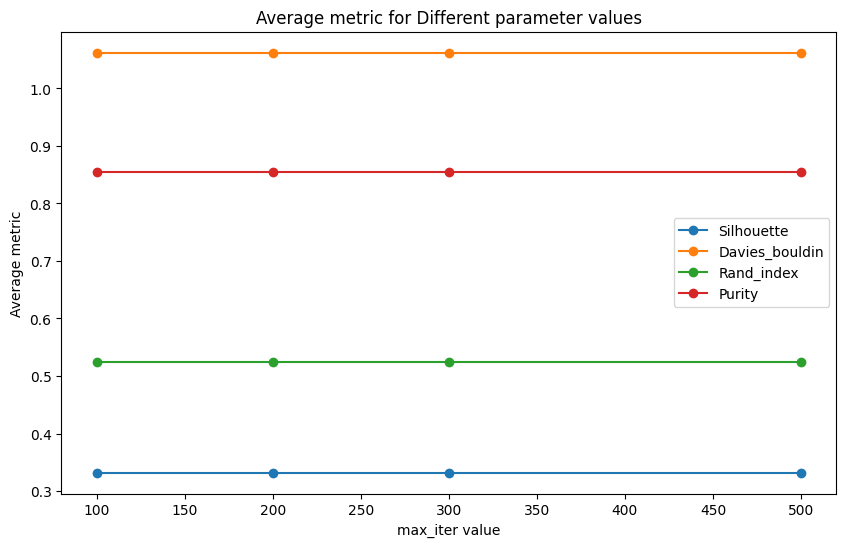

In [66]:
plot_all_avg_scores_kmeans(seeds_result)

Silhouette Score: 0.4007 => Fair
Davies-Bouldin Index: 0.9279 => Very Bad
Rand Index: 0.7733 => Good
Purity: 0.9200 => Very High


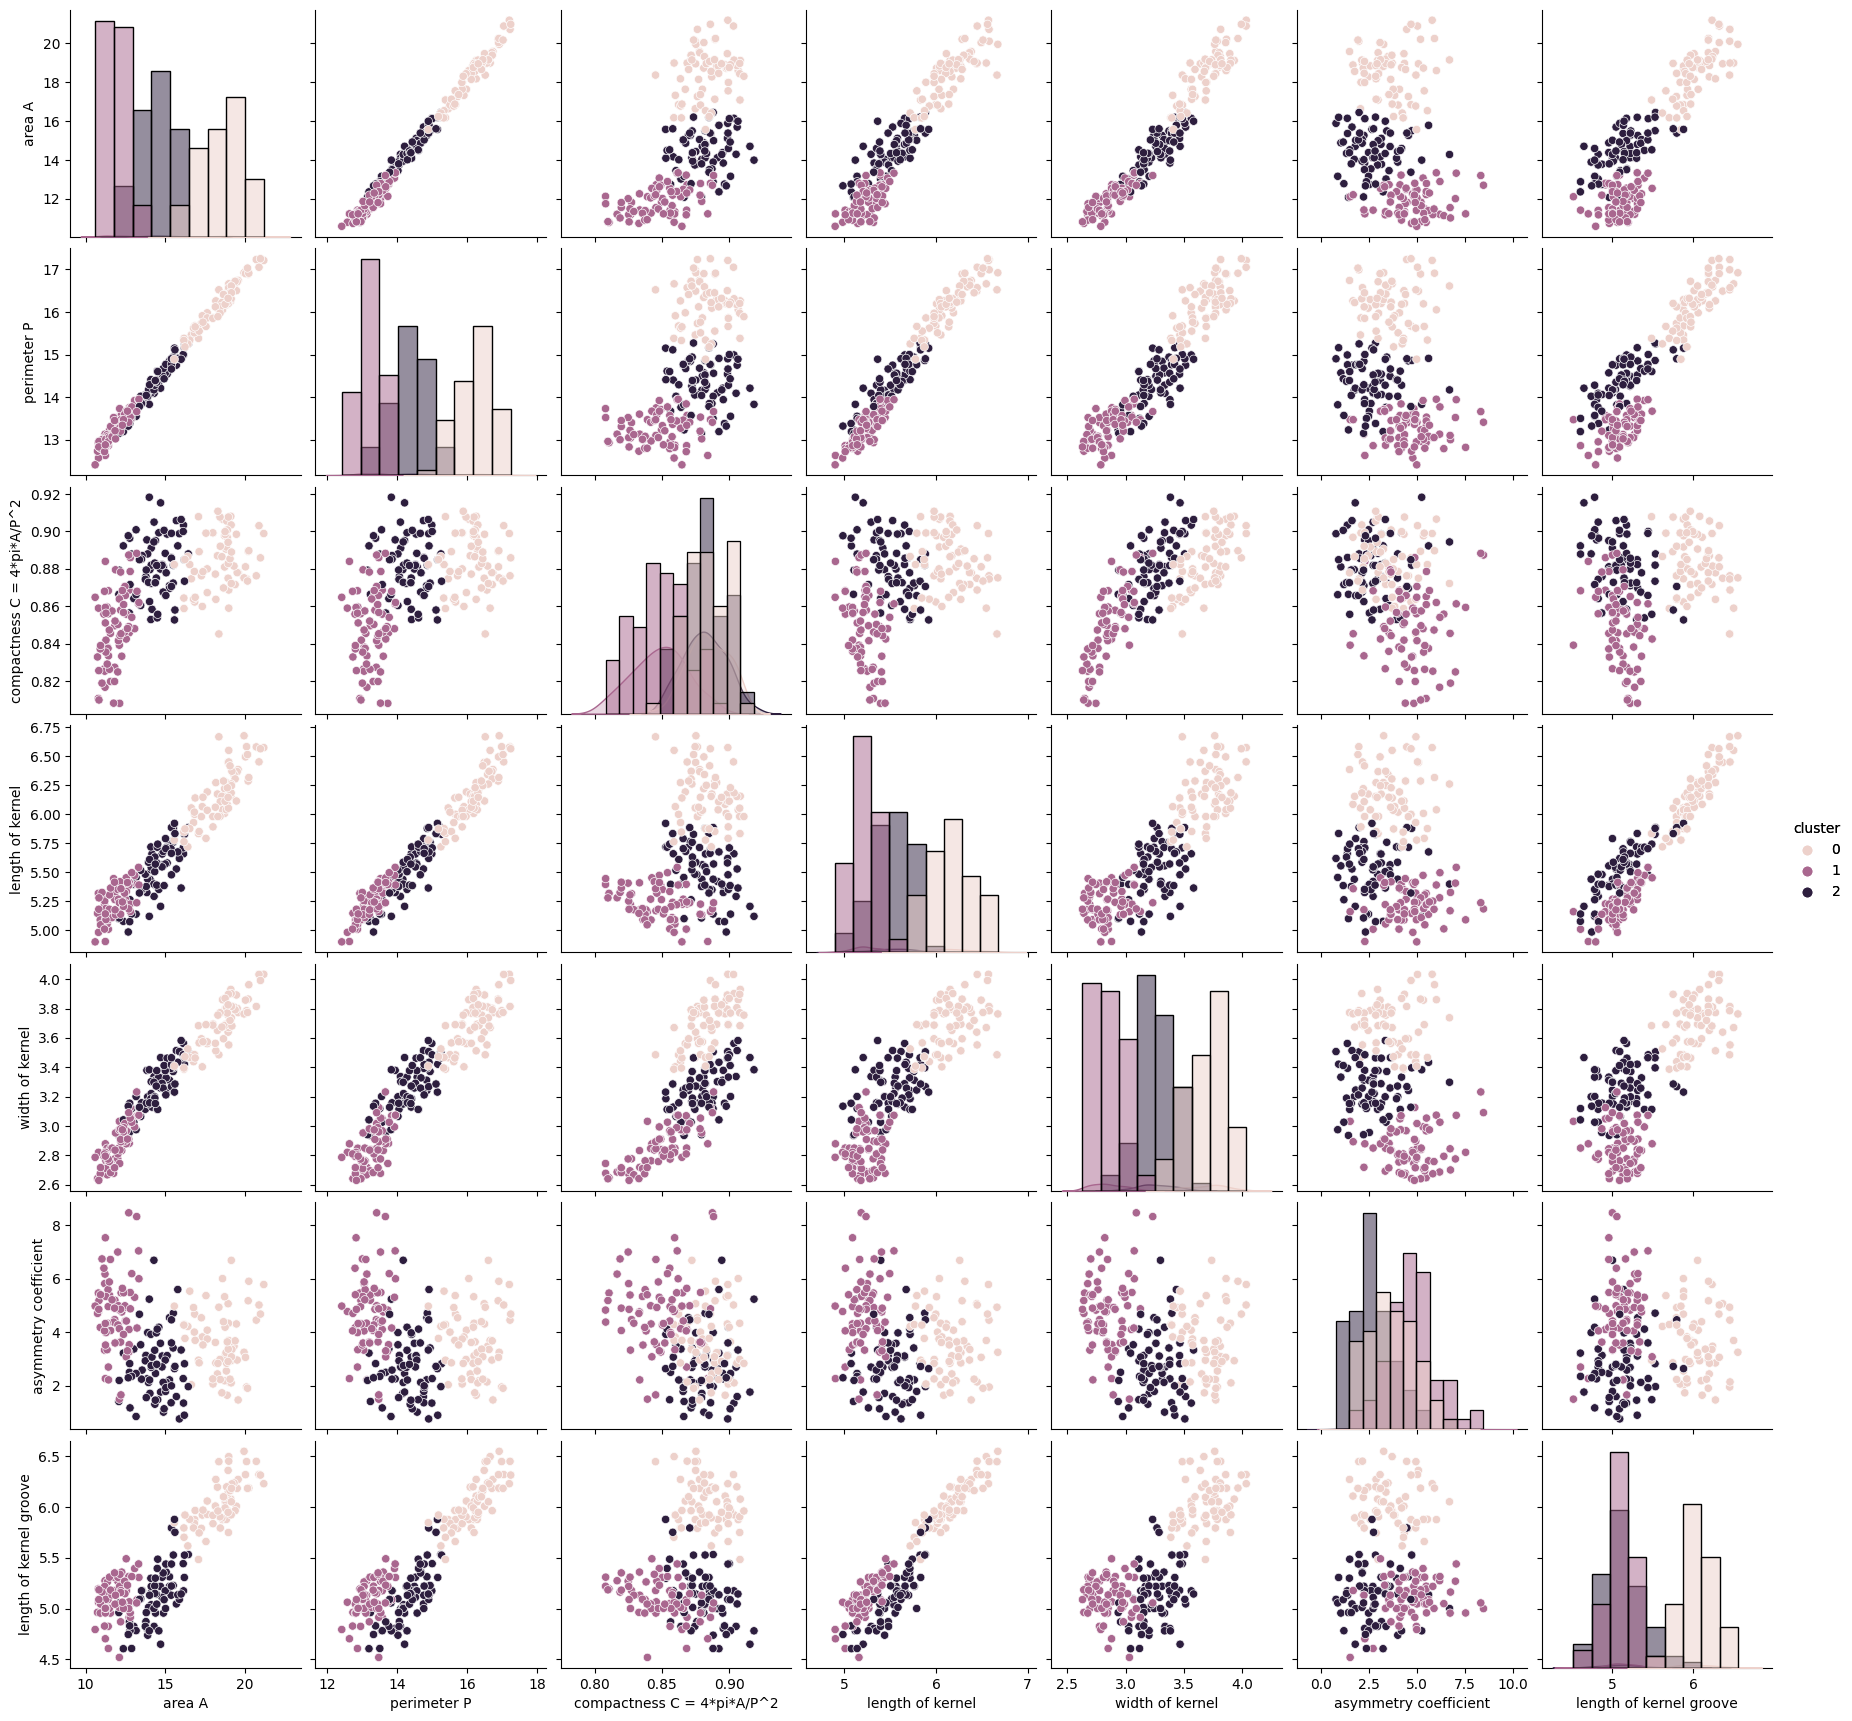

In [67]:
plot_best_kmeans(seeds_result, Seeds)

<h1>GLASS KMEANS<h1>


In [68]:
result_glass = kmeans_full_test(Glass)

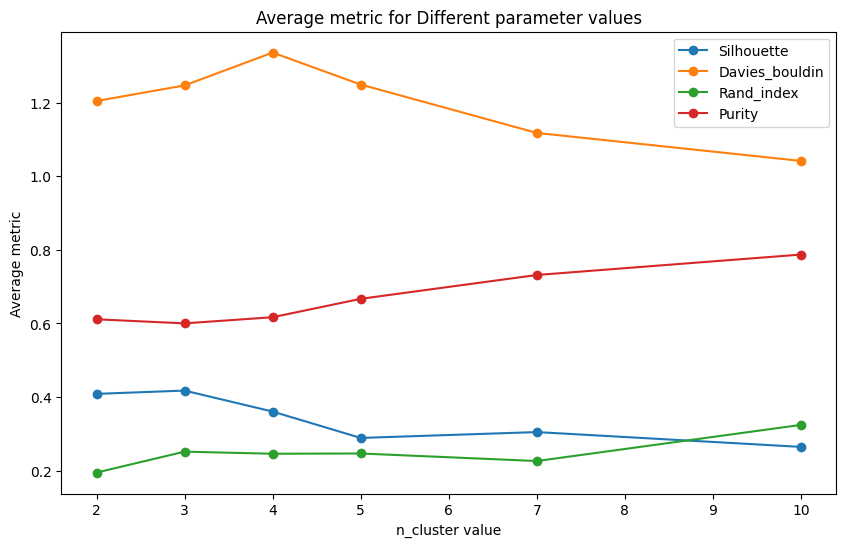

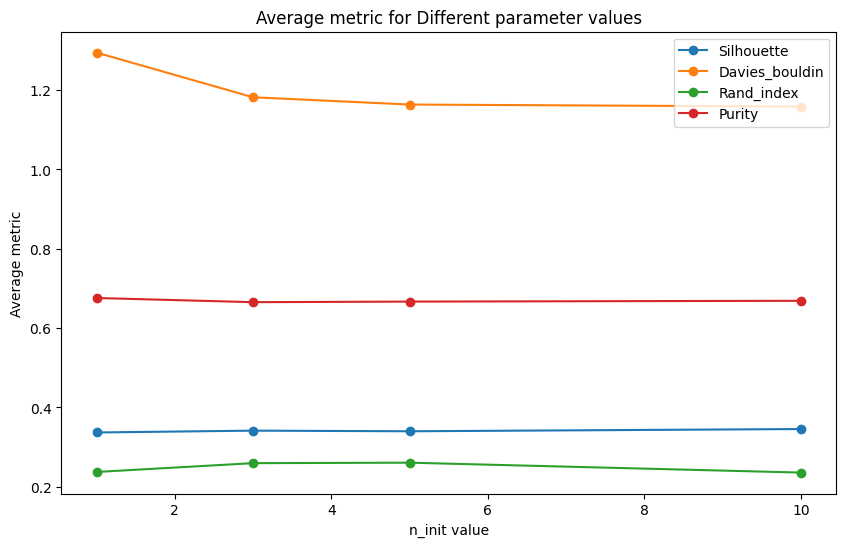

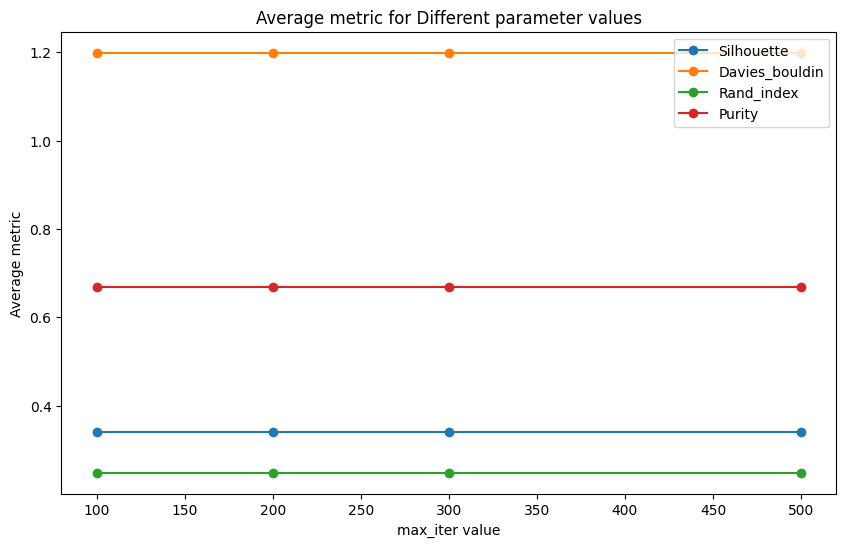

In [69]:
plot_all_avg_scores_kmeans(result_glass)

Silhouette Score: 0.2613 => Bad
Davies-Bouldin Index: 1.0302 => Very Bad
Rand Index: 0.4122 => Fair
Purity: 0.8199 => High


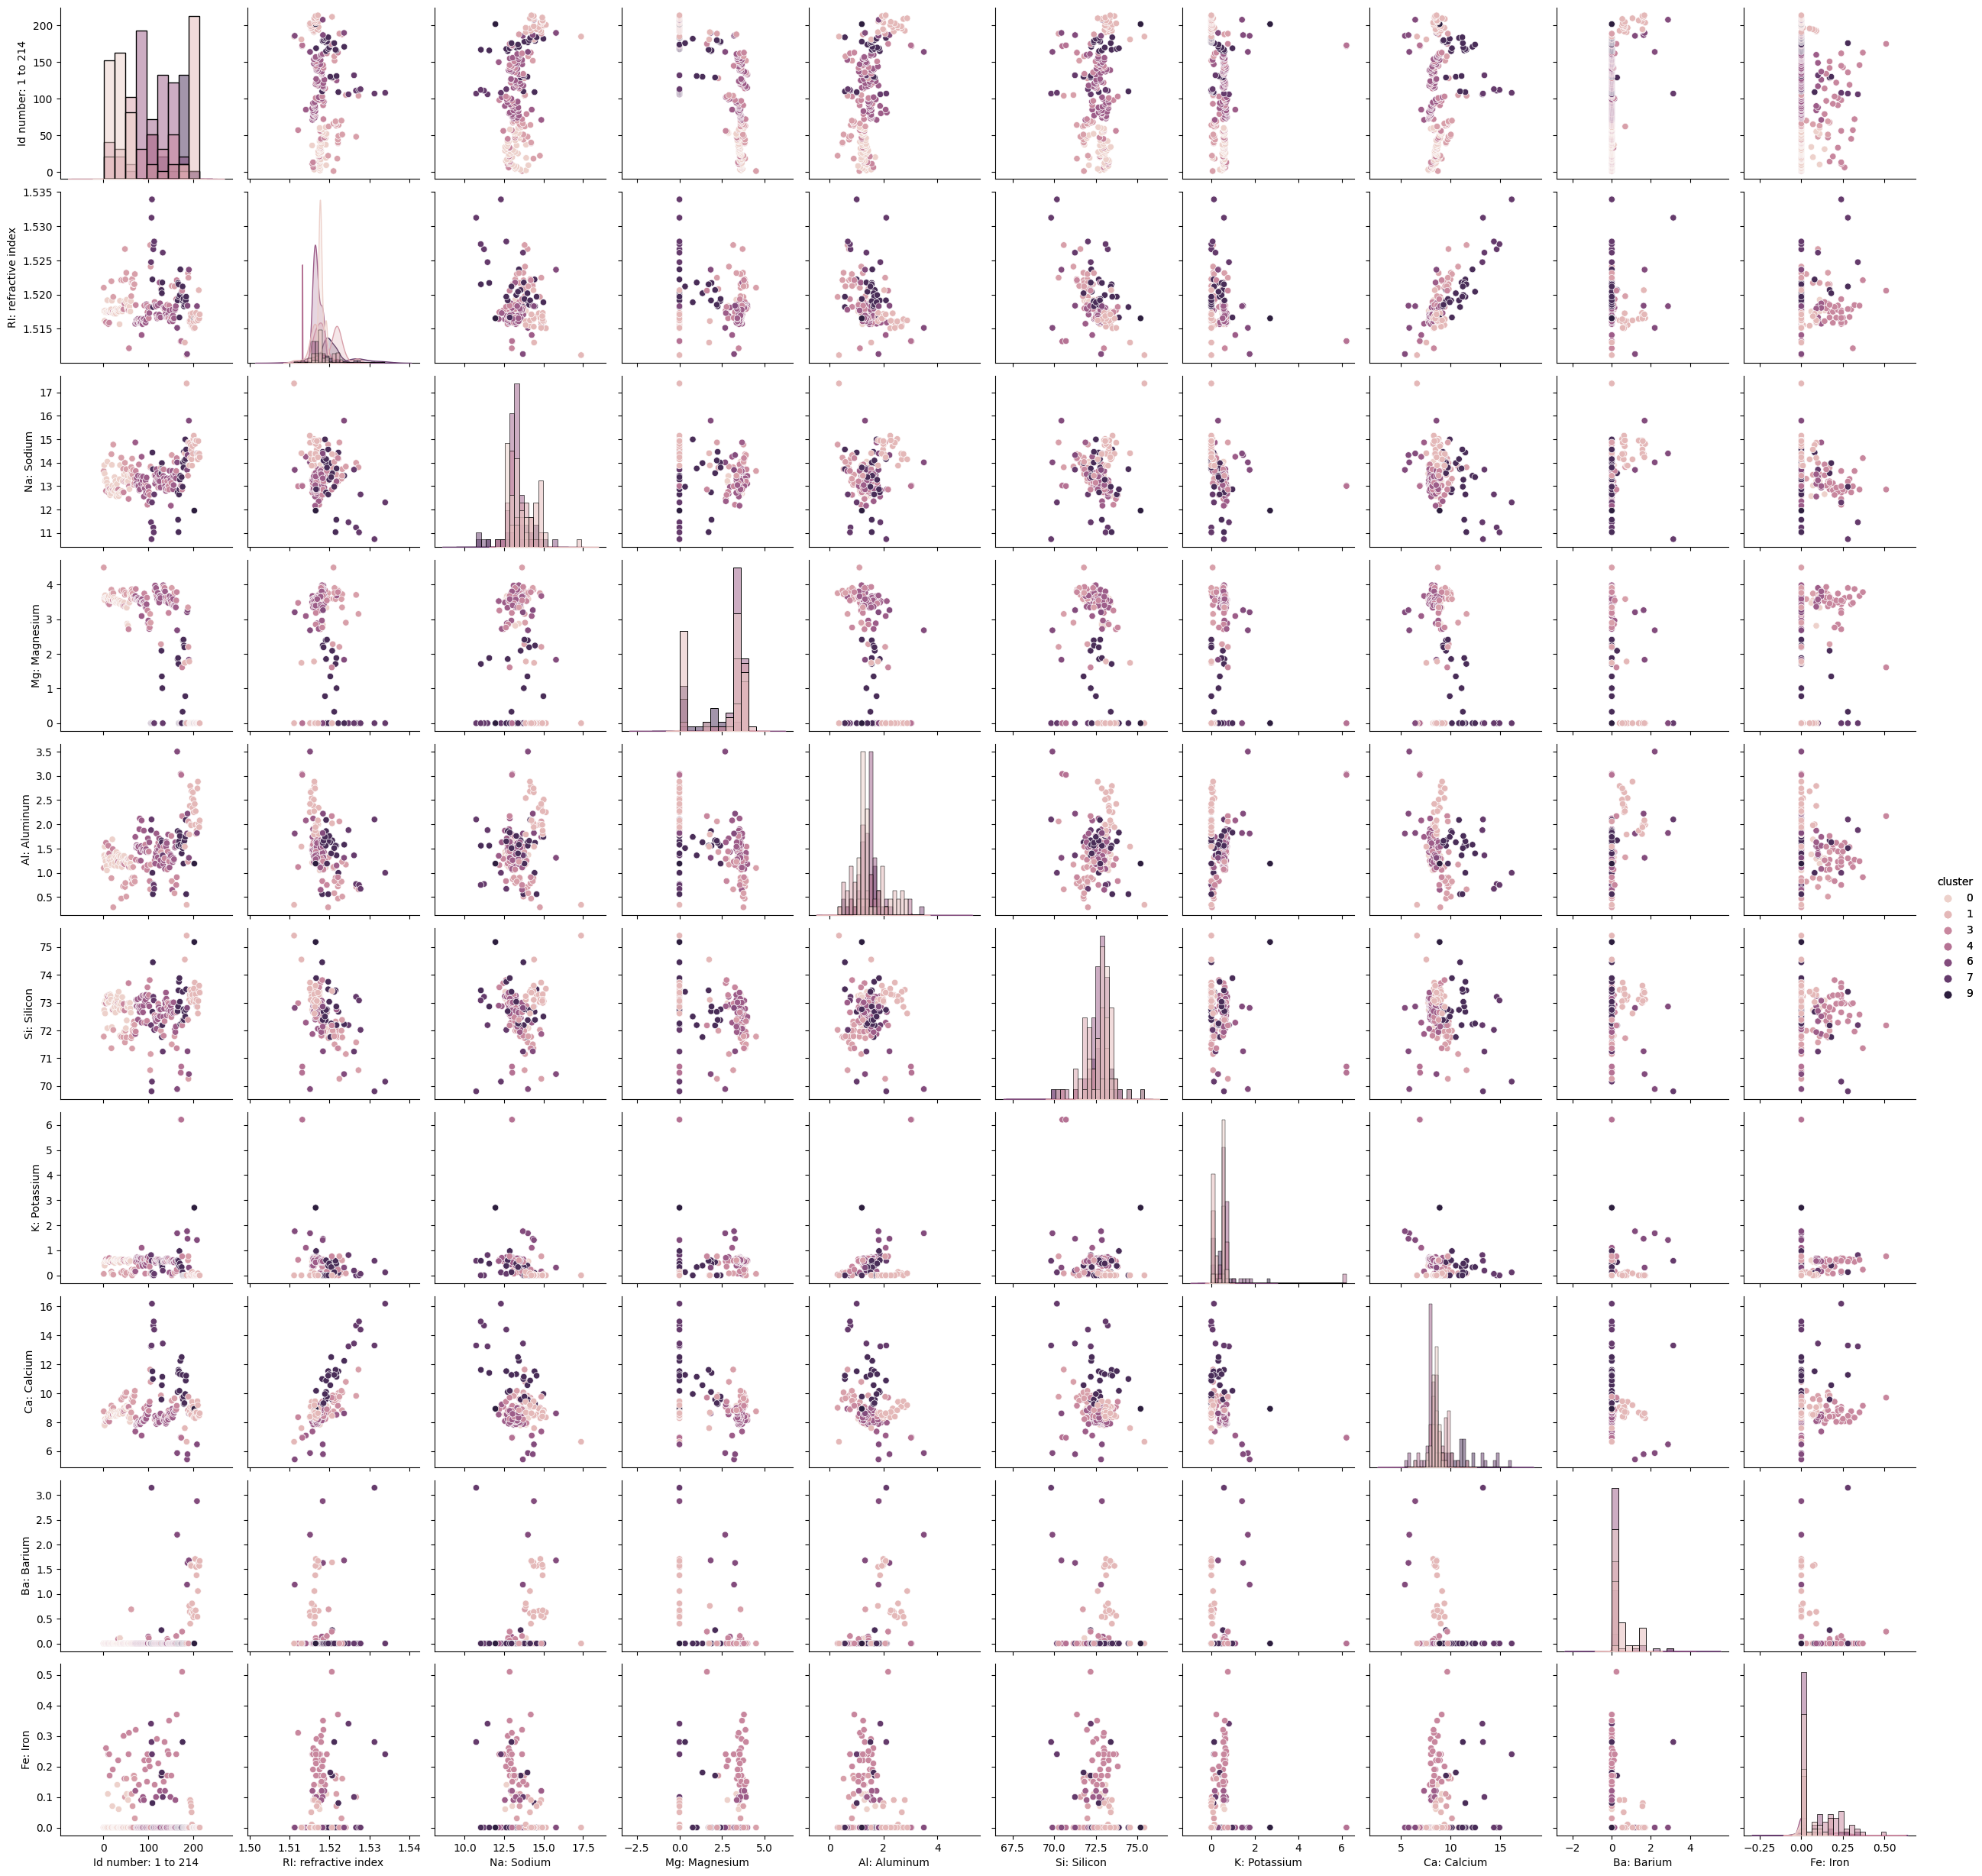

In [70]:
plot_best_kmeans(result_glass, Glass)

Silhouette Score: 0.0943 => Very Bad
Davies-Bouldin Index: 0.9803 => Very Bad
Rand Index: 0.5414 => Fair
Purity: 0.8333 => High


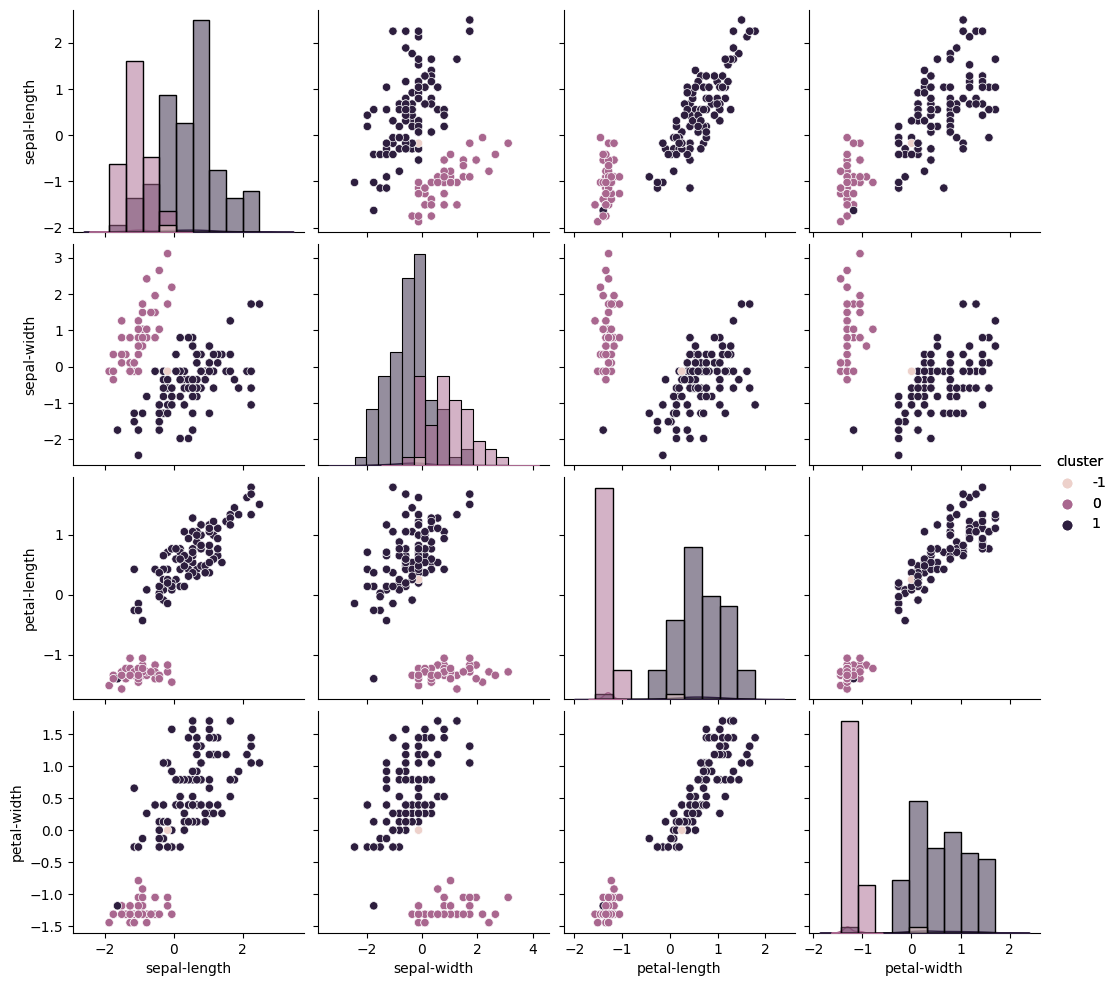

In [71]:
iris_dbscan_results = dbscab_full_test(Iris)
plot_best_dbscan(iris_dbscan_results, Iris)

<h1>Seeds DBSCAN<h1>

In [72]:
seeds_dbscan_results = dbscab_full_test(Seeds)

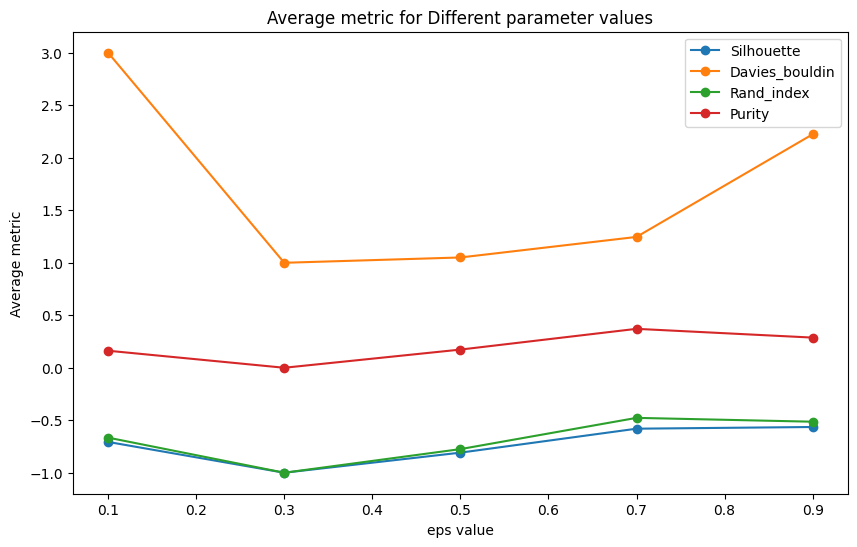

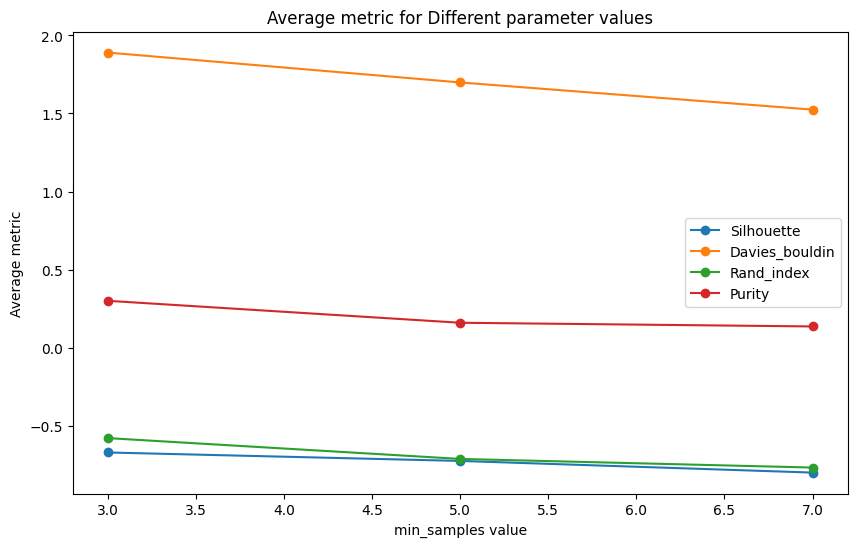

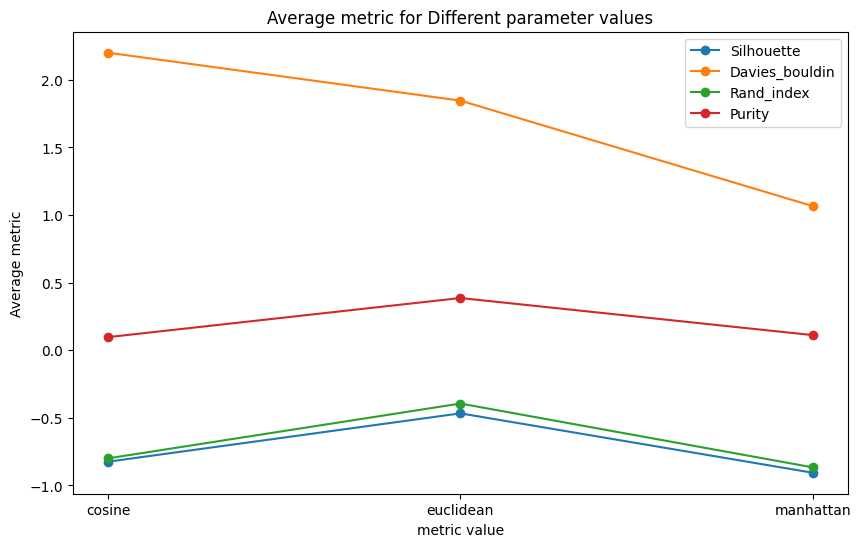

In [73]:
plot_all_avg_scores_dbscan(seeds_dbscan_results)

Silhouette Score: 0.0621 => Very Bad
Davies-Bouldin Index: 0.8569 => Very Bad
Rand Index: 0.0019 => Very Bad
Purity: 0.6707 => Moderate


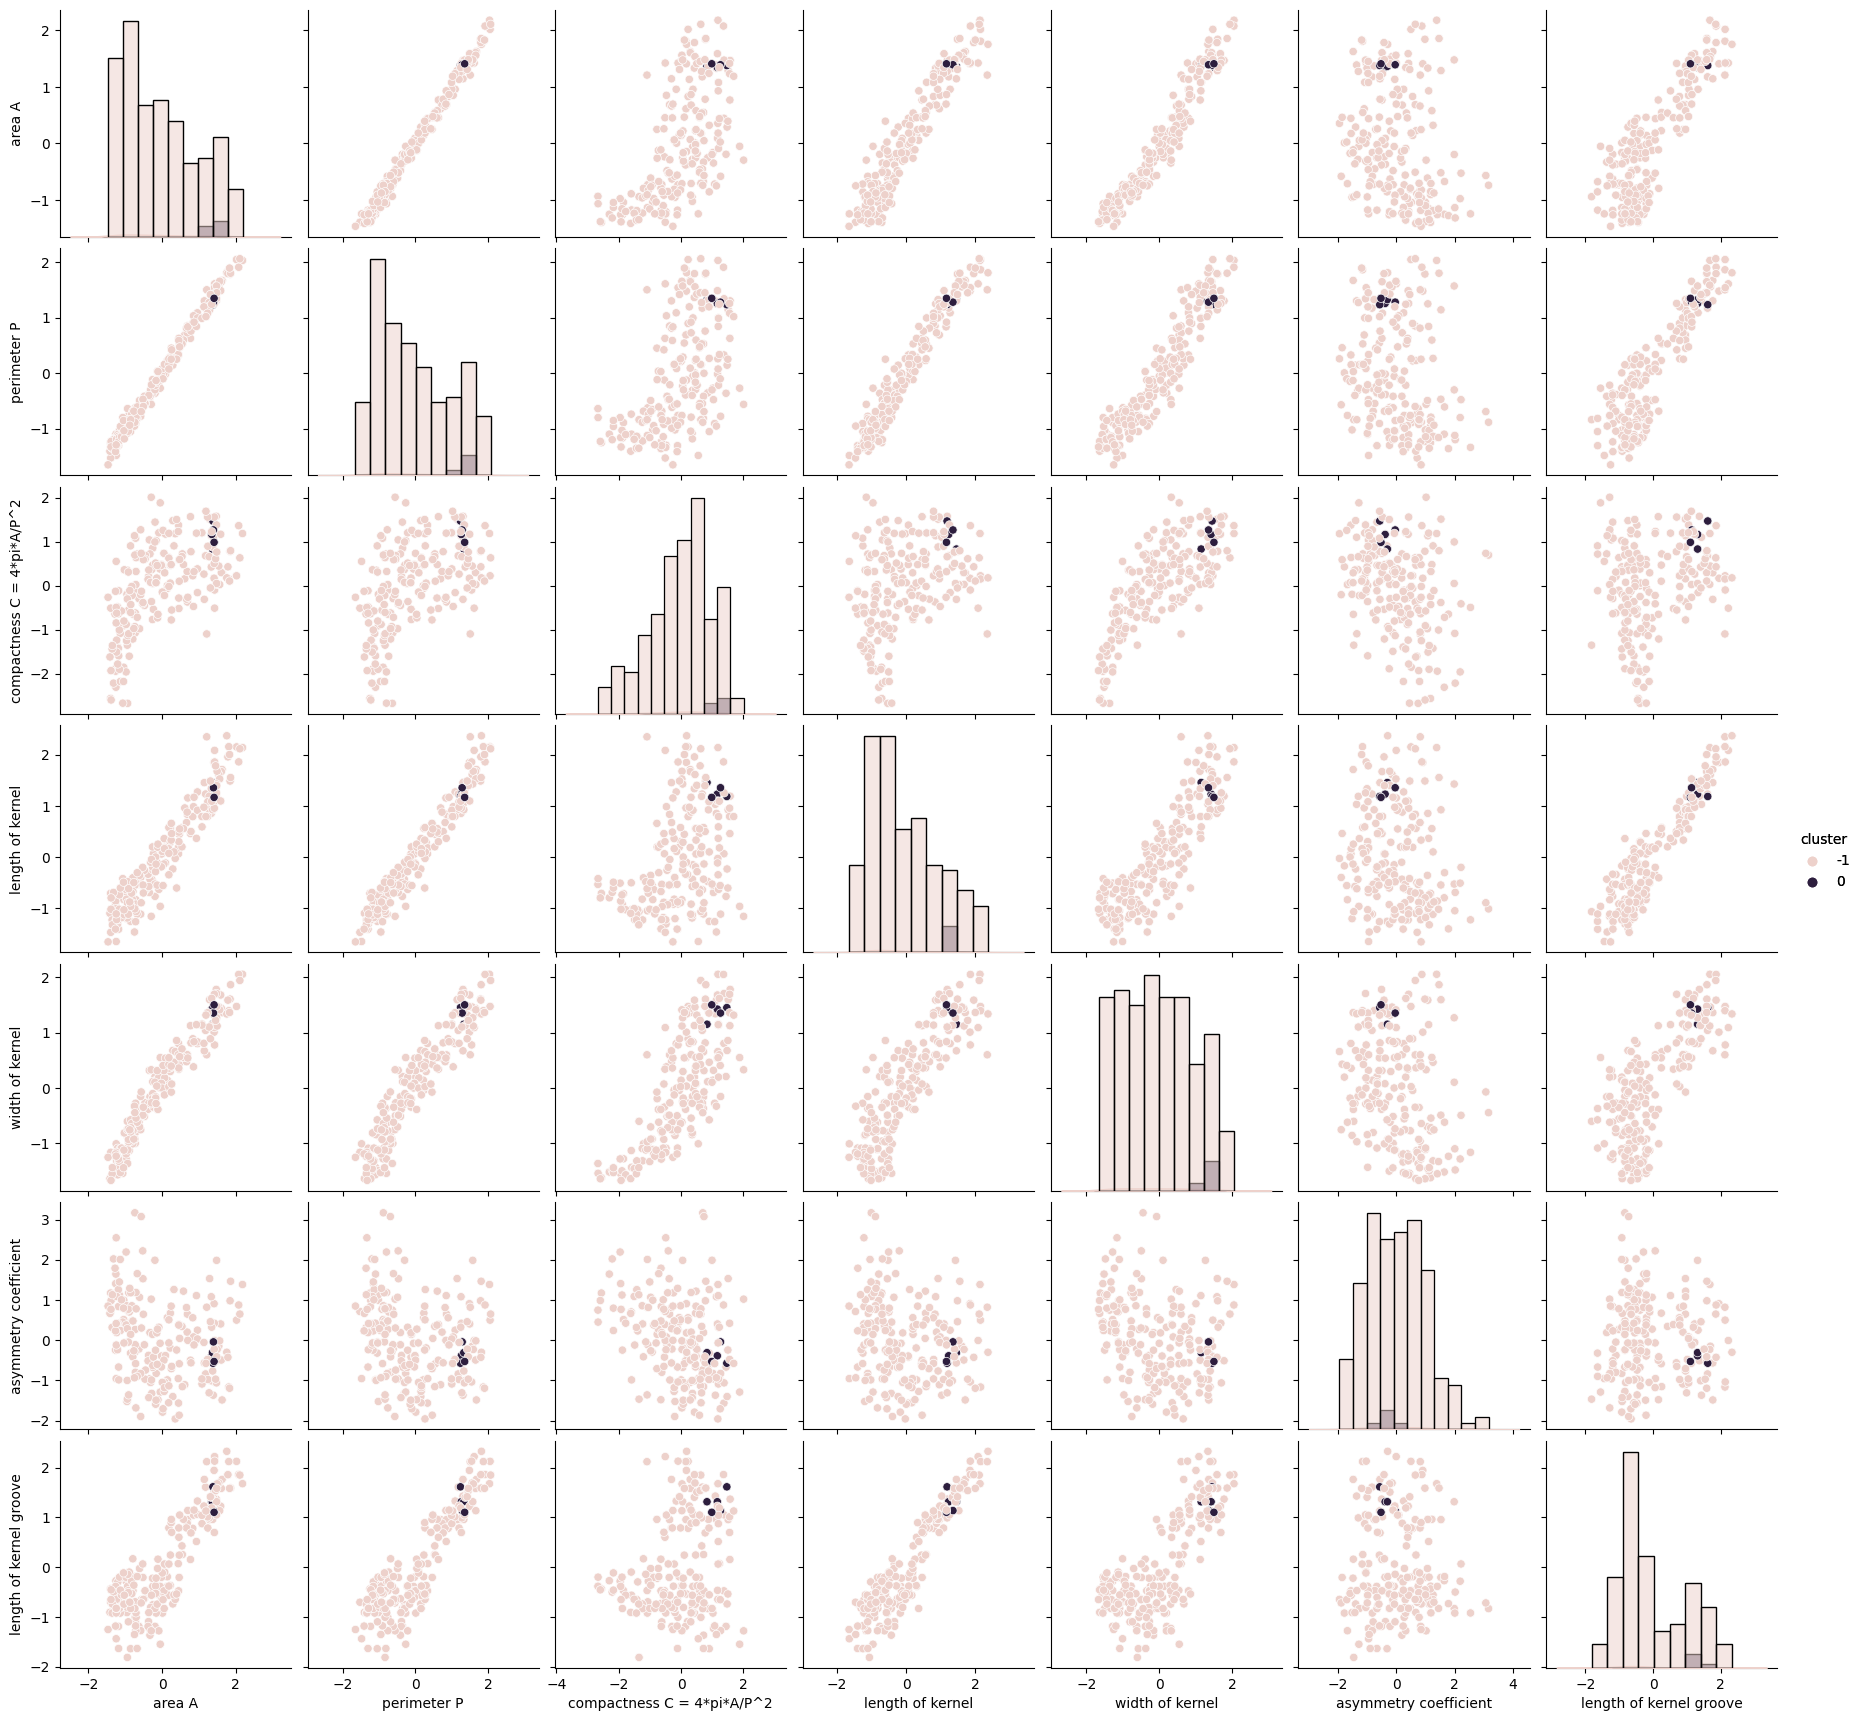

In [93]:
plot_best_dbscan(seeds_dbscan_results, Seeds)

<h1>Glass DBSCAN<h1<

In [76]:
glass_dbscan_results = dbscab_full_test(Glass)

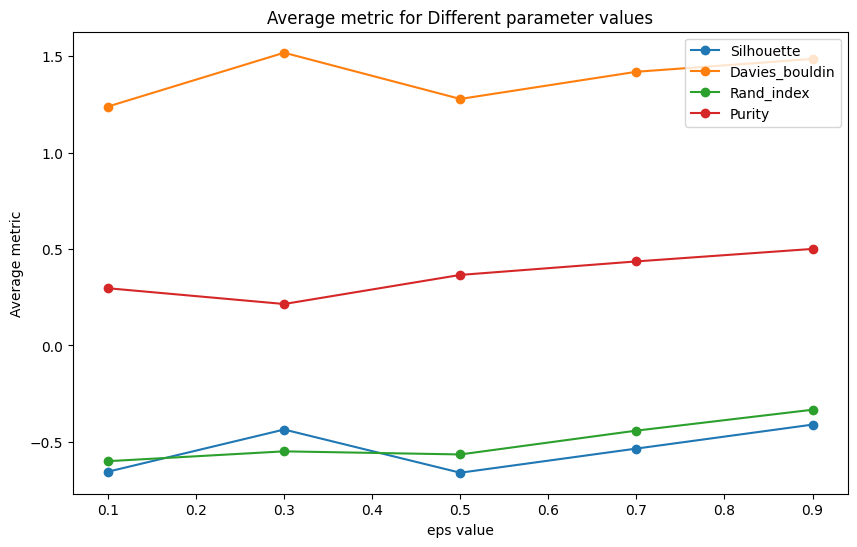

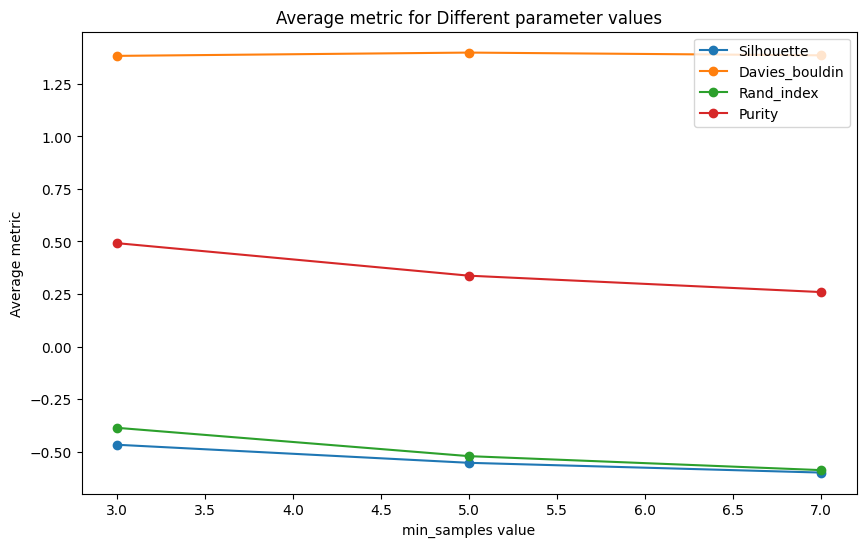

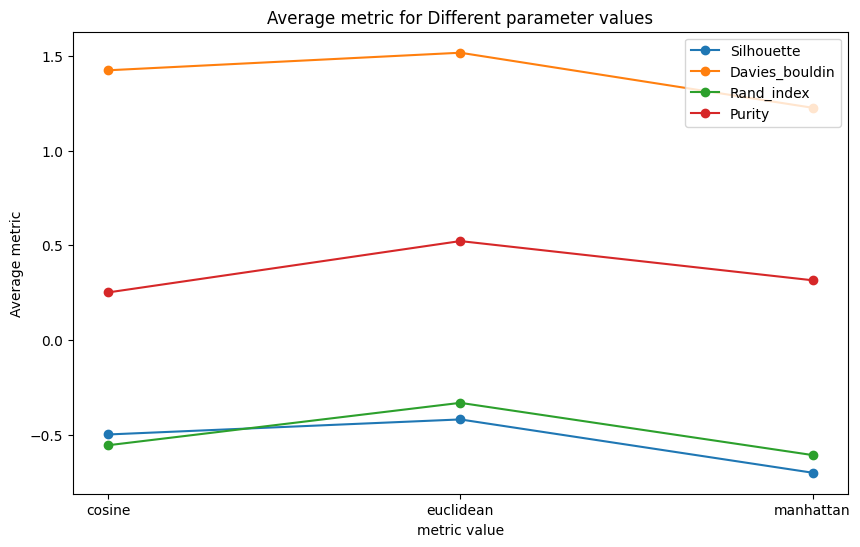

In [77]:
plot_all_avg_scores_dbscan(glass_dbscan_results)

Silhouette Score: 0.0145 => Very Bad
Davies-Bouldin Index: 1.5776 => Very Bad
Rand Index: 0.2131 => Bad
Purity: 0.9086 => Very High


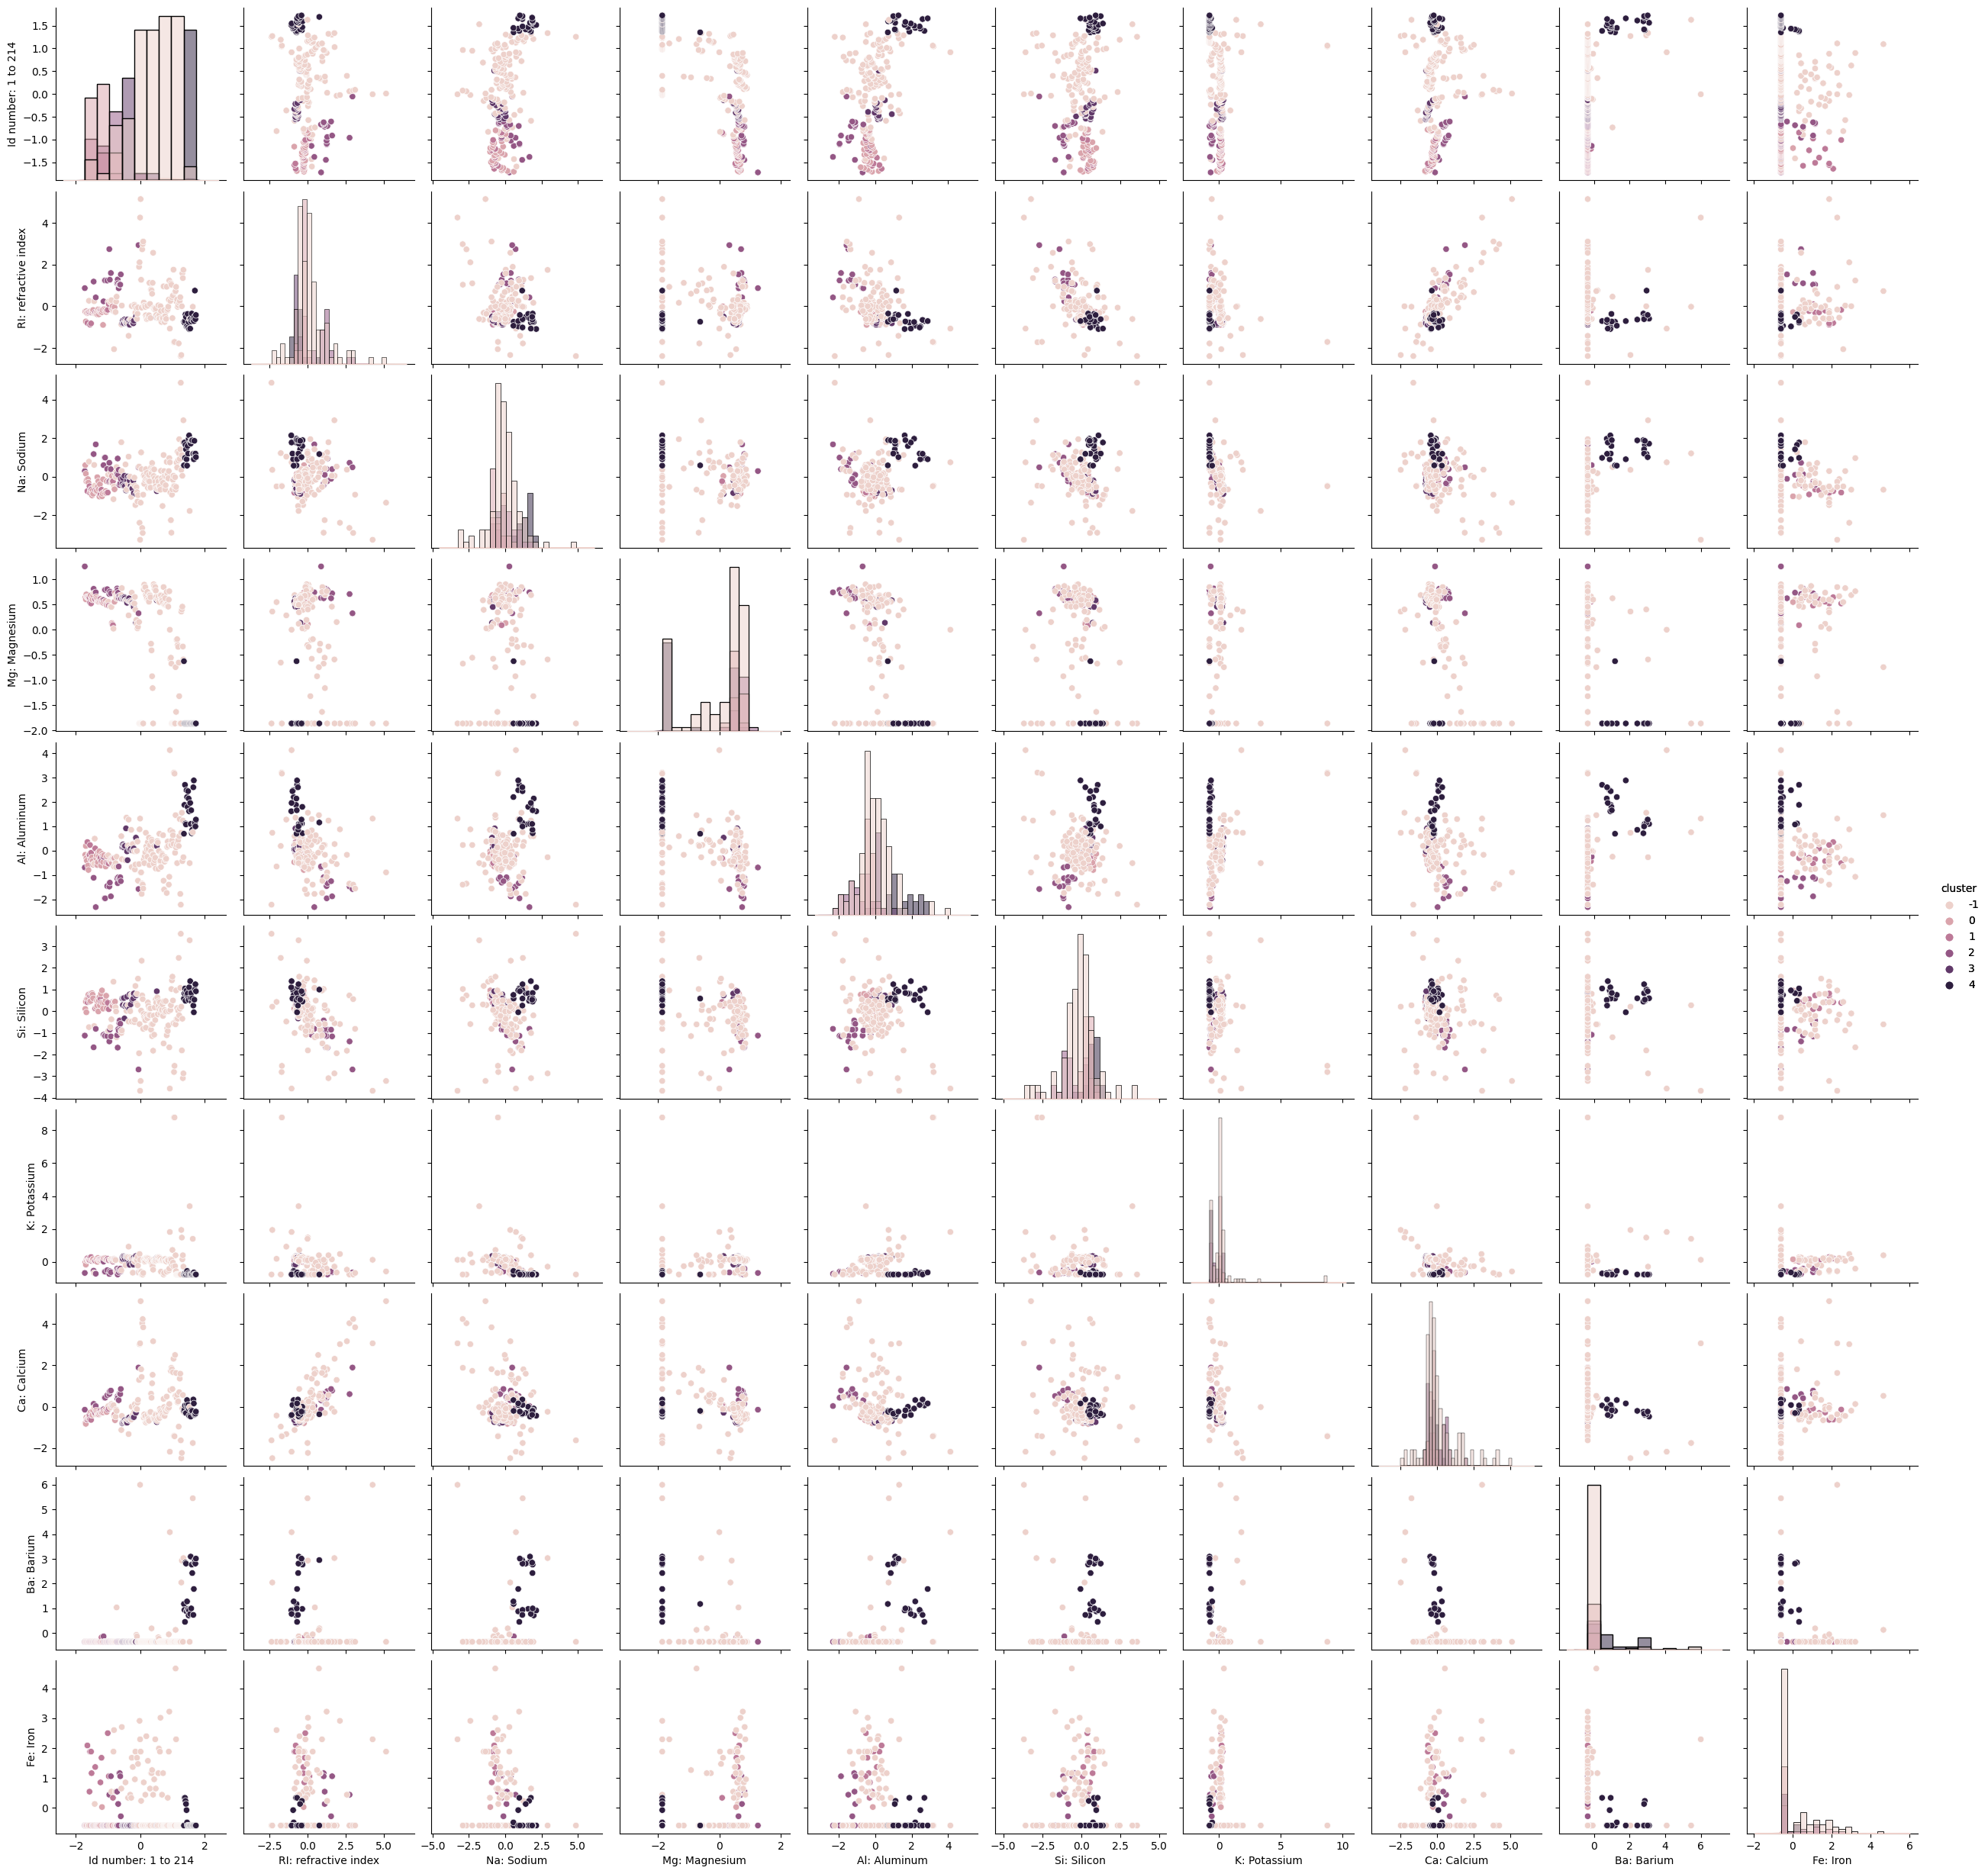

In [78]:
plot_best_dbscan(glass_dbscan_results, Glass)

<h1>Porównanie k-means i DBSCAN<h1>

<h3>Miary oparte na etykietach (ground truth):</h3>

Adjusted Rand Index (ARI): Mierzy podobieństwo pomiędzy przydzielonymi przez algorytm klastrami a prawdziwymi etykietami. Wartość ARI wynosi od -1 do 1, gdzie 1 oznacza doskonałe dopasowanie klastrów do etykiet.

Purity: Oblicza procent punktów przypisanych do najczęściej występującej etykiety w klastrze. Wartość purity mieści się w zakresie od 0 do 1, gdzie 1 oznacza idealne dopasowanie klastrów do etykiet.

<h3>Miary nieuwzględniające etykiet:</h3>

Silhouette Score: Mierzy jak dobrze punkty pasują do swoich klastrów w porównaniu z innymi klastrami. Wartość silhouette score jest między -1 a 1, gdzie wyższe wartości oznaczają lepszą separację klastrów.

Davies-Bouldin Index (DBI): Ocenia jakość klastrów na podstawie odległości między klastrami i wewnętrznej spójności klastrów. Wartość DBI jest większa lub równa 0, a mniejsze wartości oznaczają lepszą separację klastrów

<ol>
  <li>
    <div>
      Silhouette Score
    </div>
    <ul>
      <li>
        W przypadku zbioru danych "seeds", oba algorytmy, K-means i DBSCAN, uzyskały podobny wynik Silhouette Score (0.4007), co wskazuje na wynik oceniany jako "Fair" (średni)
      </li>
      <li>
        Dla zbioru danych "Glass", DBSCAN uzyskał nieco lepszy wynik Silhouette Score (0.4190) w porównaniu do K-means (0.3736), ale oba wyniki są na poziomie "Fair" (średni).
      </li>
    </ul>
  </li>
  <li>
    <div>
      Davies-Bouldin Index
    </div>
    <ul>
      <li>
        Zarówno dla zbioru danych "seeds", jak i "Glass", wyniki dla obu algorytmów (K-means i DBSCAN) wskazują na wysokie wartości Davies-Bouldin Index. Oznacza to, że oceniana jakość klastrów jest "Very Bad" (bardzo zła) dla obu przypadków.
      </li>
    </ul>
  </li>
  <li>
    <div>
      Rand Index
    </div>
    <ul>
      <li>
        Dla zbioru danych "seeds", zarówno K-means, jak i DBSCAN, uzyskały dobre wyniki Rand Index (0.7733), co wskazuje na dobrą zgodność przydzielonych klastrów w porównaniu do prawdziwych etykiet.
      </li>
      <li>
        Dla zbioru danych "Glass", wynik Rand Index był niższy dla obu algorytmów (0.3120 dla K-means i 0.2608 dla DBSCAN), co wskazuje na słabą zgodność z prawdziwymi etykietami klastrów.
      </li>
    </ul>
  </li>
  <li>
    <div>
      Purity
    </div>
    <ul>
      <li>
        Dla zbioru danych "seeds", zarówno K-means, jak i DBSCAN, uzyskały bardzo wysokie wartości Purity (0.9200), co oznacza bardzo dobrą zgodność przydzielonych klastrów z prawdziwymi etykietami.
      </li>
      <li>
        Dla zbioru danych "Glass", wartość Purity była nieco niższa dla obu algorytmów (0.6958 dla K-means i 0.5953 dla DBSCAN), co wskazuje na umiarkowaną zgodność klastrów z prawdziwymi etykietami.
      </li>
    </ul>
  </li>
</ol>

Podsumowując, wyniki wskazują, że K-means i DBSCAN mają podobne wyniki dla metryk Silhouette Score i Rand Index na zbiorze danych "seeds". Jednak dla metryki Davies-Bouldin Index wyniki są bardzo złe dla obu algorytmów w obu przypadkach.

Dla zbioru danych "Glass", oba algorytmy uzyskały niższe wyniki dla metryki Silhouette Score, a wyniki Davies-Bouldin Index wskazują na bardzo złe jakości klastrów dla obu algorytmów. Natomiast wyniki Rand Index były słabsze dla obu algorytmów w przypadku tego zbior

<h1>Analiza wizualizacji</h1>
Zaczynając od zestawu danych "glass", widzimy, że algorytm k-means osiągnął lepsze wyniki w trzech z czterech używanych metryk. Silhouette Score, który mierzy spójność klastrów, jest wyższy dla k-means, co sugeruje, że ten algorytm jest lepszy w tworzeniu gęstych i dobrze odseparowanych klastrów dla tego zestawu danych. Podobnie, Rand Index, który mierzy podobieństwo klastrów do prawdziwych grup, jest również wyższy dla k-means. Oznacza to, że k-means lepiej przewiduje prawdziwe grupy w tych danych.

Jednakże, pomimo gorszych wyników dla DBSCAN w tych dwóch metrykach, warto zauważyć, że DBSCAN osiągnął wyższy wynik Purity, co oznacza, że mimo wszystko jest zdolny do tworzenia klastrów z dominującymi klasami.

Jednakże, pomimo gorszych wyników dla DBSCAN w tych dwóch metrykach, warto zauważyć, że DBSCAN osiągnął wyższy wynik Purity, co oznacza, że mimo wszystko jest zdolny do tworzenia klastrów z dominującymi klasami.

Porównując oba algorytmy na zestawie danych "seed", widzimy, że k-means znacznie przewyższa DBSCAN we wszystkich czterech metrykach. Silhouette Score, Davies-Bouldin Index, i Rand Index są znacznie wyższe dla k-means, co wskazuje, że algorytm ten tworzy lepiej skupione i odseparowane klastery, które są bardziej zgodne z prawdziwymi grupami w tych danych. Ponadto, k-means ma również wyższy wynik Purity, co oznacza, że jest zdolny do tworzenia klastrów z dominującymi klasami.

<h1>PCB<h1>

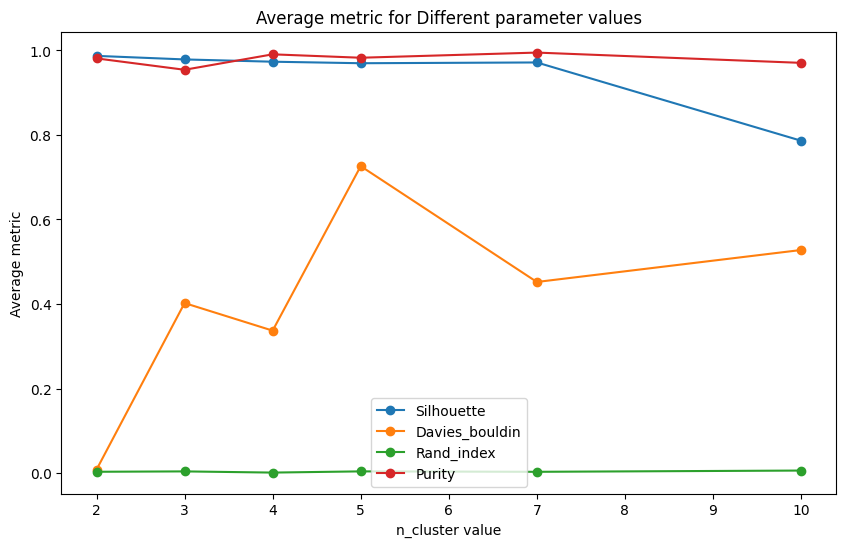

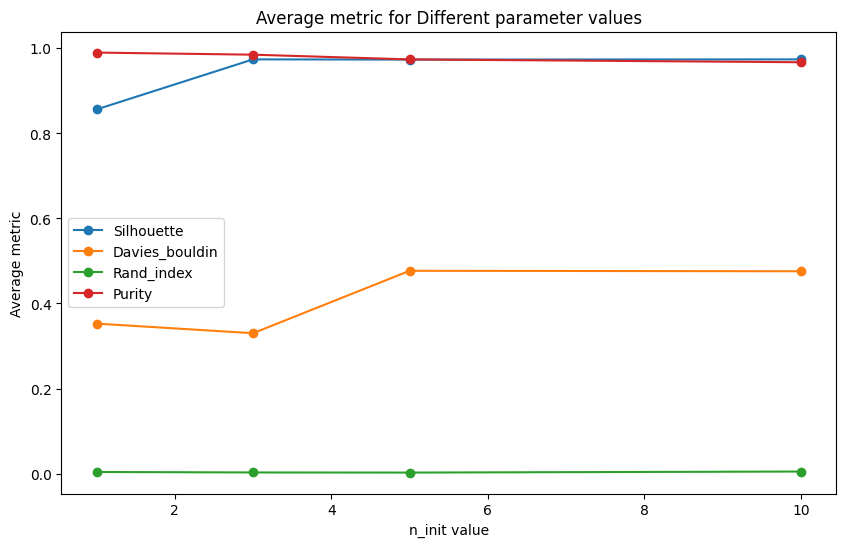

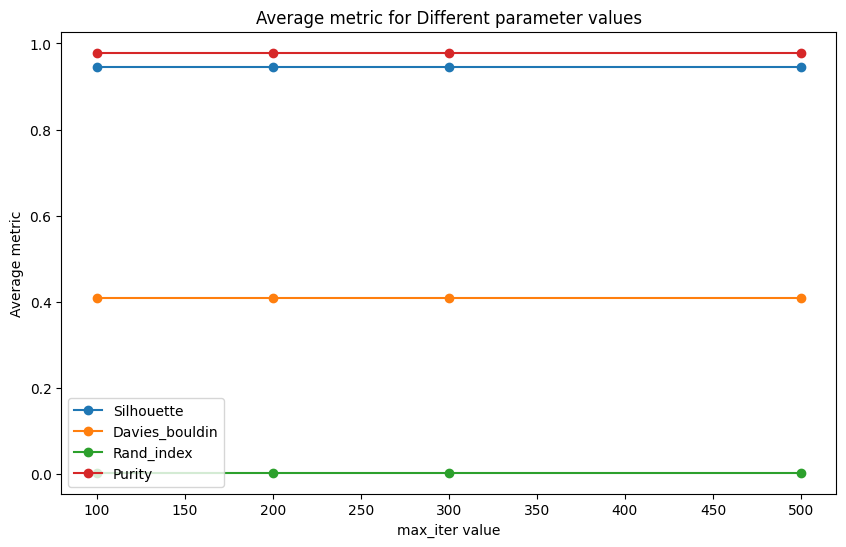

Silhouette Score: 0.9825 => Very Good
Davies-Bouldin Index: 0.0094 => Very Good
Rand Index: 0.0062 => Very Bad
Purity: 0.9904 => Very High


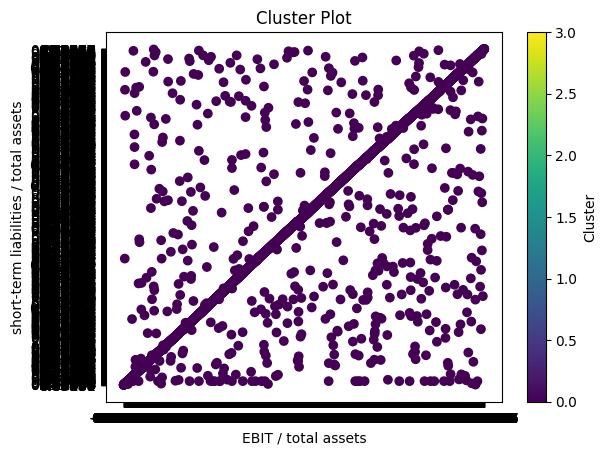

In [91]:
pcb_kmeans_results = kmeans_full_test(Pcb)
plot_all_avg_scores_kmeans(pcb_kmeans_results)
get_scores_for_best_kmeans_with_plot(
    pcb_kmeans_results,
    Pcb,
    "EBIT / total assets",
    "short-term liabilities / total assets",
)

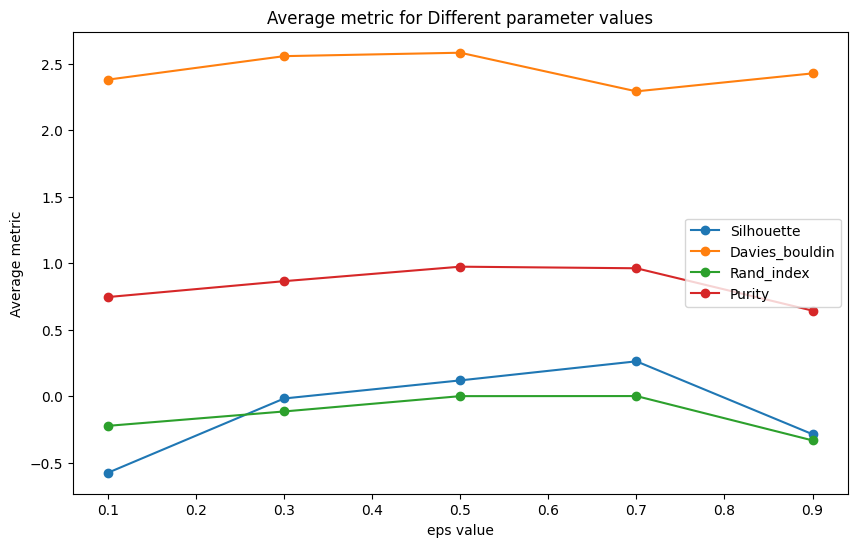

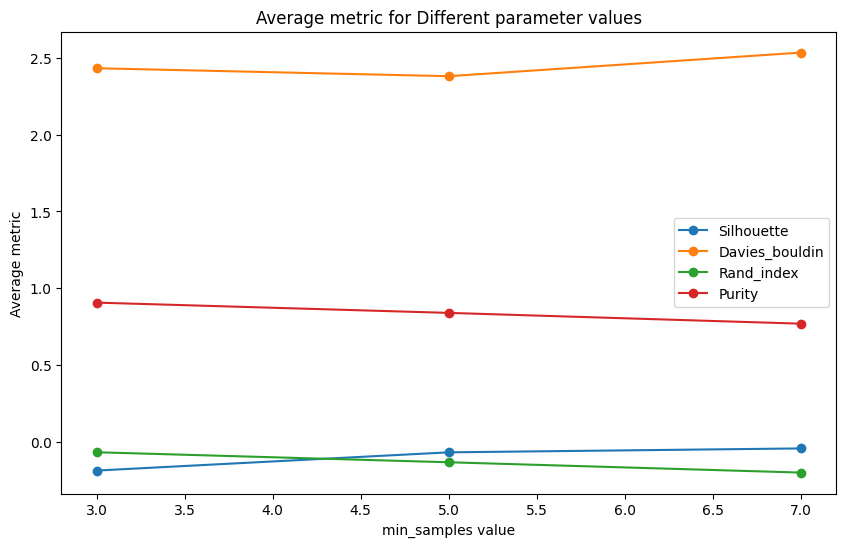

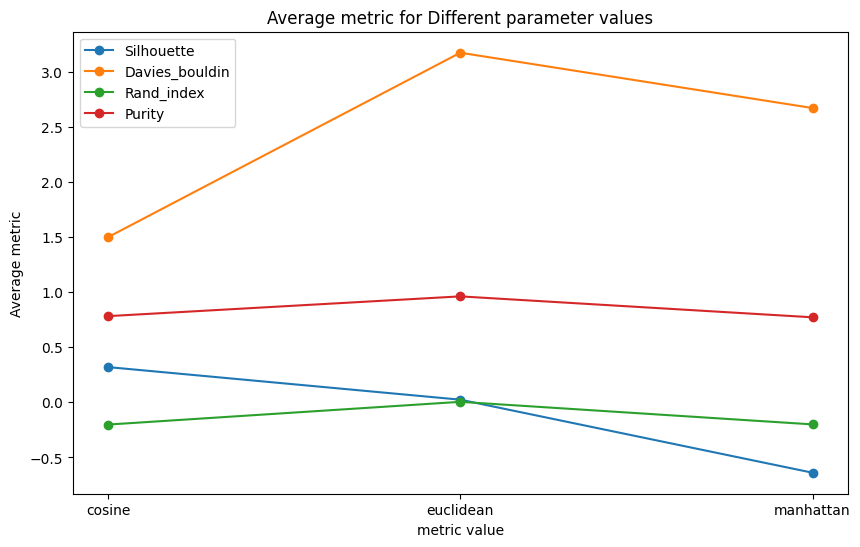

Silhouette Score: 0.9898 => Very Good
Davies-Bouldin Index: 0.0063 => Very Good
Rand Index: -0.0003 => Very Bad
Purity: 0.9807 => Very High


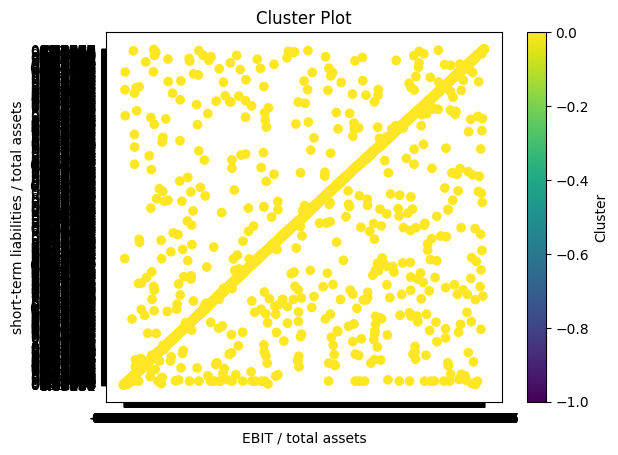

In [92]:
pcb_dbscan_results = dbscab_full_test(Pcb)
plot_all_avg_scores_dbscan(pcb_dbscan_results)
get_scores_for_best_dbscan_with_plot(
    pcb_dbscan_results,
    Pcb,
    "EBIT / total assets",
    "short-term liabilities / total assets",
)

Wyniki dla obu algorytmów są bardzo porównywalne.